# Clustering on Walmart data 
* [Data Load/Pre-processing](#data_process)
* [Clustering](#clust)
    * [1-D Clustering](#clust_1d)
        * [Discretization](#clust_1d_binning)
            * [Equal Size Binning](#clust_1d_binning_equal)
            * [Kmeans Binning](#clust_1d_binning_kmeans)
        * [Kmeans Clustering](#clust_1d_kmeans_clust) 
    * [2-D Clustering](#clust_2d)
        * [Kmeans W/O Normalization](#clust_2d_kmeans_no_norm)
        * [Kmeans W/ Normalization](#clust_2d_kmeans_norm)
        * [Hierarchical Clustering - <font color='red'> Kernel Keeps Dying Due to large data size - Not done</font>](#clust_2d_agglomerative)
    * [n-D Clustering](#clust_nd)
        * [Data Dummified](#clust_nd_dummies)
        * [Data for n-D Clustering](#clust_nd_data_clustering)
        * [KMeans Clustering W/O Normalization](#clust_nd_kmeans_no_norm)
            * [Optimal Number of clusters using Elbow curve](#clust_nd_kmeans_no_norm_elbow)
            * [kmeans with 3 clusters](#clust_nd_kmeans_no_norm_3)  
            * [Analysis of Results](#clust_nd_kmeans_no_norm_analysis)
        * [KMeans Clustering W/ Normalization](#clust_nd_kmeans_norm)
            * [Optimal Number of clusters using Elbow/Silhouette curve - - <font color='red'> Unable to compute SSilhouette score - this and following subsection Not Done</font>](#clust_nd_kmeans_norm_elbow_silh)
            * [kmeans with 3 clusters](#clust_nd_kmeans_norm_3)  
            * [Analysis of Results](#clust_nd_kmeans_norm_analysis)
    * [n-D Clustering with PCA](#clust_nd_pca)
        * [Normalizating whole data](#clust_nd_pca_norm)
        * [Dimentionality Reduction](#clust_nd_pca_pca)
        * [Kmeans on Reduced X ](#clust_nd_pca_kmeans)
        * [Hierarchical on Reduced X - <font color='red'> Kernel Keeps Dying Due to large data size - Not done</font>](#clust_nd_pca_aglomerative)
        

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

<a class="anchor" id ="data_process"></a>

# Dataload and Pre-processsing 

In [2]:
stores =  pd.read_csv('dataset/walmart/stores.csv')
sales  =  pd.read_csv('dataset/walmart/sales.csv')

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421568 entries, 0 to 421567
Data columns (total 5 columns):
Store           421568 non-null int64
Dept            421568 non-null int64
Date            421568 non-null object
Weekly_Sales    421568 non-null float64
IsHoliday       421568 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [4]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
Store    48 non-null float64
Type     47 non-null object
Size     48 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB


In [5]:
# Clean stores data to remove duplicates and missing record 
# <<KNOW this from previous analysis, refer to Walmart data EDA notebook>>

stores.drop_duplicates(inplace=True)
stores.dropna(inplace=True)
# Merge Sales and Stores data
walmart = pd.merge(sales, stores, how='inner')  

walmart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421568 entries, 0 to 421567
Data columns (total 7 columns):
Store           421568 non-null int64
Dept            421568 non-null int64
Date            421568 non-null object
Weekly_Sales    421568 non-null float64
IsHoliday       421568 non-null bool
Type            421568 non-null object
Size            421568 non-null float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 22.9+ MB


In [6]:
# Convert Date to datetime Type
walmart['Date'] = pd.to_datetime(sales['Date'])

# Add additional columns derived from date 

walmart = walmart.assign(day_name = walmart['Date'].dt.day_name(), 
                         isWeekend = np.select ([(walmart['Date'].dt.dayofweek).isin([5,6])], 
                                      [1], default=0 ),
                         quarter = walmart['Date'].dt.quarter, 
                         month = walmart['Date'].dt.month
                         )
walmart.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421568 entries, 0 to 421567
Data columns (total 11 columns):
Store           421568 non-null int64
Dept            421568 non-null int64
Date            421568 non-null datetime64[ns]
Weekly_Sales    421568 non-null float64
IsHoliday       421568 non-null bool
Type            421568 non-null object
Size            421568 non-null float64
day_name        421568 non-null object
isWeekend       421568 non-null int64
quarter         421568 non-null int64
month           421568 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 35.8+ MB


In [7]:
# Convert cateogorical variables to 'Categorical Type'
cat_var = ['IsHoliday', 'day_name', 'isWeekend', 'quarter', 'month', 'Type']

for cat in cat_var:
    walmart[cat] = pd.Categorical(walmart[cat])

# for applying ML Model's ignoring store_id, dept_id and date     
data = walmart[['month', 'quarter', 'isWeekend', 'day_name', 'IsHoliday',
                'Size', 'Type', 'Weekly_Sales' ]]

walmart.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 421568 entries, 0 to 421567
Data columns (total 11 columns):
Store           421568 non-null int64
Dept            421568 non-null int64
Date            421568 non-null datetime64[ns]
Weekly_Sales    421568 non-null float64
IsHoliday       421568 non-null category
Type            421568 non-null category
Size            421568 non-null float64
day_name        421568 non-null category
isWeekend       421568 non-null category
quarter         421568 non-null category
month           421568 non-null category
dtypes: category(6), datetime64[ns](1), float64(2), int64(2)
memory usage: 21.7 MB


In [8]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,day_name,isWeekend,quarter,month
0,1,1,2010-12-02,46039.49,True,A,151315.0,Thursday,0,4,12
1,1,1,2010-02-19,41595.55,False,A,151315.0,Friday,0,1,2
2,1,1,2010-02-26,19403.54,False,A,151315.0,Friday,0,1,2
3,1,1,2010-05-03,21827.90,False,A,151315.0,Monday,0,2,5
4,1,1,2010-12-03,21043.39,False,A,151315.0,Friday,0,4,12


In [9]:
walmart.Type.unique()

[A, B, C]
Categories (3, object): [A, B, C]

<a class="anchor" id ="clust"></a>

# CLUSTERING 

Things to consider:

    * Do I need to scale data? 
    * How do my results differ when I scale data vs non-scaled data for kmeans?
    * Do I need to scale data for Hierarchical Clustering?
    * Are there any categorical variables in the data that I need to dummify?
    * Does it make sense to do clustering on dummified data?
    * Do I need to normalize dummified data?
    * What parameters do I need to specify?
    * Can I plot my results of clustering? Explain the reasoning
    



<a class="anchor" id ="clust_1d"></a>
## GOAL-1: Cluster stores based on size and analyze if same sizes fall under same cluster as in original data    

- Reference Links: 
    https://towardsdatascience.com/an-introduction-to-discretization-in-data-science-55ef8c9775a2


In [10]:
'''Max/Min store Size'''
walmart['Size'].min() , walmart['Size'].max()

(34875.0, 219622.0)

In [11]:
'''Max/Min store Size by Types given in the dataset'''
walmart.groupby(by='Type')['Size'].agg({'min', 'max'})

,max,min
Type,,
A,219622.0,39690.0
B,140167.0,34875.0
C,42988.0,39690.0


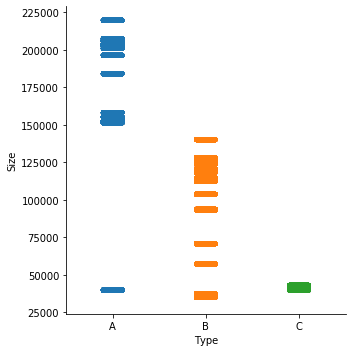

In [12]:
sns.catplot(x='Type', y='Size', data =walmart)
plt.show()

Apperntly it looks that size is not the cler indicator of Type because sizes overlap in three sore Types

Since we are trying to predict if the 'Type' in the given datset are based on 'size of the store' only, We can 

1) discretize/data into 3 bins and 

2) apply clustering algorithm  

 <a class="anchor" id ="clust_1d_binning"></a>
### Discretization

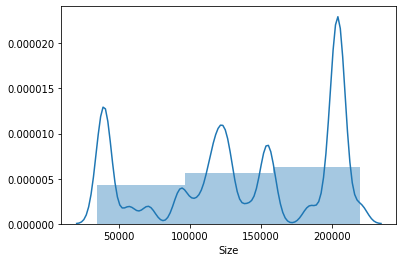

In [13]:
sns.distplot(walmart['Size'], hist=True, bins=3)
plt.show()

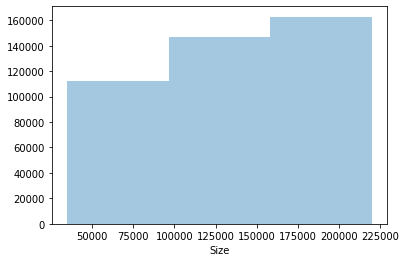

In [14]:
sns.distplot(walmart['Size'], hist=True, bins=3, kde=False)
plt.show()

<a class="anchor" id ="clust_1d_binning_equal"></a>
#### Equal Size bins 
pandas cut() function creates bins. 

In [15]:
walmart['size_bucket'] = pd.cut(x= walmart['Size'].values, bins= 3, labels =[0,1,2])
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,day_name,isWeekend,quarter,month,size_bucket
0,1,1,2010-12-02,46039.49,True,A,151315.0,Thursday,0,4,12,1
1,1,1,2010-02-19,41595.55,False,A,151315.0,Friday,0,1,2,1
2,1,1,2010-02-26,19403.54,False,A,151315.0,Friday,0,1,2,1
3,1,1,2010-05-03,21827.90,False,A,151315.0,Monday,0,2,5,1
4,1,1,2010-12-03,21043.39,False,A,151315.0,Friday,0,4,12,1


In [16]:
np.unique(walmart['size_bucket'])

array([0, 1, 2])

In [17]:
walmart.groupby(by ='size_bucket')['Size'].agg({'min', 'max', 'count'})

,count,max,min
size_bucket,,,
0,111865,93638.0,34875.0
1,146944,155083.0,103681.0
2,162759,219622.0,158114.0


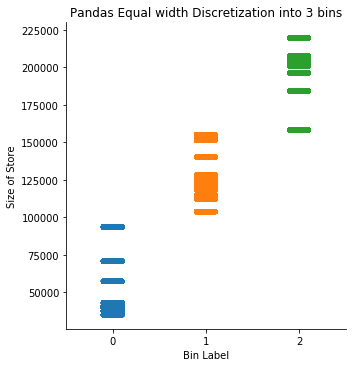

In [18]:
sns.catplot(x='size_bucket', y = 'Size', data =walmart)

plt.title('Pandas Equal width Discretization into 3 bins')
plt.ylabel('Size of Store')
plt.xlabel('Bin Label')
#TODO draw dashed line between categories 

plt.show()

<a class="anchor" id ="clust_1d_binning_kmeans"></a>
#### Kmeans based binning 

In [19]:
from sklearn.preprocessing import KBinsDiscretizer

In [20]:
Xc= walmart['Size'].values
Xc = Xc.reshape(-1,1)

discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
walmart['size_bucket_kmean'] = discretizer.fit_transform(Xc)

In [21]:
walmart['size_bucket_kmean'].unique()

array([1., 2., 0.])

In [22]:
walmart.groupby(by = 'size_bucket_kmean')['Size'].agg({'count', 'min', 'max'})

,count,max,min
size_bucket_kmean,,,
0.0,92546,70713.0,34875.0
1.0,176487,158114.0,93188.0
2.0,152535,219622.0,184109.0


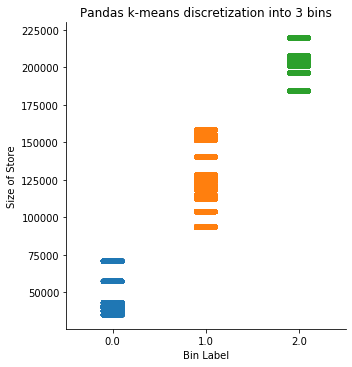

In [23]:
sns.catplot(x='size_bucket_kmean', y='Size', data =walmart)

plt.title('Pandas k-means discretization into 3 bins')
plt.ylabel('Size of Store')
plt.xlabel('Bin Label')

plt.show()

These are very different from original bins and equal width based binning

<a class="anchor" id ="clust_1d_kmeans_clust"></a>
### Kmeans Clustering 

- For k-means clustering, to find the optimal number of bins we'll use elbow curve and see if choice of three clusters aligns as in the given dataset

In [24]:
from sklearn.cluster import KMeans

In [25]:
Xc= walmart['Size'].values
yc = walmart['Type'].values
Xc.shape, yc.shape

((421568,), (421568,))

In [26]:
# kmeans() functions takes a matrix of rows and columns 

#Using RESHAPE() to convert array to 
# -1 in reshape() function will keep that dimension as it is and where we add 1 it'll add another dimesnion
# This way are array is converted into rows and columns
Xc = Xc.reshape(-1,1)

Xc.shape, Xc.ndim

((421568, 1), 2)

In [27]:
# converting Type to labels for comparison 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(yc)

yc = le.transform(yc)
np.unique(yc) , le



(array([0, 1, 2]), LabelEncoder())

In [28]:
wcss = []
# Xc must be a n*1 matrix
# inertia_  == WCSS 
for i in range(1,15):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=0)
    kmeans.fit(Xc)
    wcss.append(kmeans.inertia_)
    


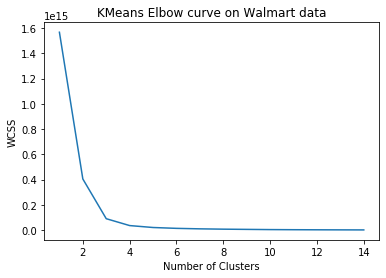

In [29]:
# Elbow plot 
plt.plot(range(1,15), wcss)    
plt.title('KMeans Elbow curve on Walmart data')
plt.ylabel('WCSS')
plt.xlabel('Number of Clusters')
plt.show()

At n_cluster = 3 is elbow meaning its where increasing the size of clusters is not reducing the 'within cluster sum squared' distance OR in other words when we have three clusters WCSS is minimized. 

Let's do clustering with 3 clusters

In [30]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
# alternate approach 
#k_labels = kmeans.fit_predict(Xc)
kmeans.fit(Xc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [31]:
k_labels = kmeans.labels_

In [32]:
walmart['k_mean_label'] = k_labels

In [33]:
cluster_centers = kmeans.cluster_centers_

In [34]:
np.unique(k_labels)

array([0, 1, 2], dtype=int32)

In [35]:
kmeans.inertia_

90010521243558.36

Now lets compare our results with original labels

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
cm = confusion_matrix(yc, k_labels)
cm

array([[152535,  12709,  50233],
       [     0,  37240, 126254],
       [     0,  42597,      0]])

In [38]:
#sns.heatmap(cm, annot=True)  # doesnt make sense using it 

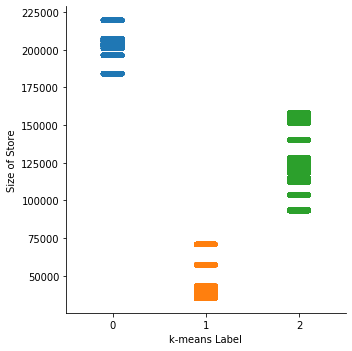

In [39]:
sns.catplot(x= 'k_mean_label', y ='Size', data =walmart)
plt.ylabel('Size of Store')
plt.xlabel('k-means Label')
plt.show()

/Users/adeela/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


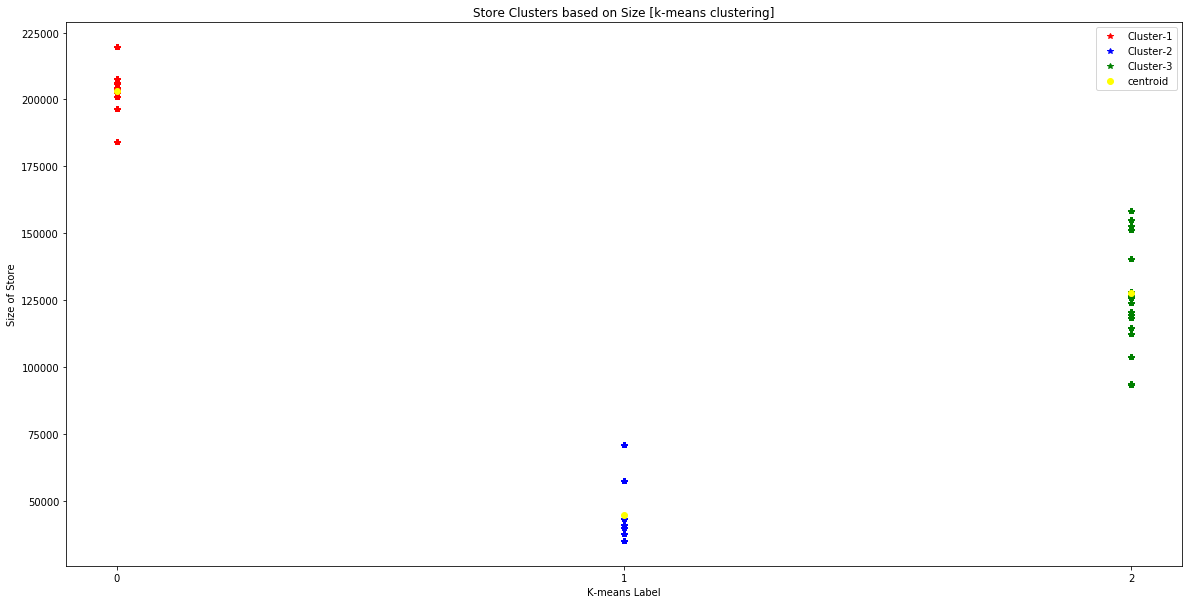

In [40]:
fig, ax= plt.subplots(figsize=(20,10))
ax.set_xticks([0,1,2])

plt.plot(k_labels[k_labels == 0], walmart[k_labels == 0]['Size'],'*', color='red', label ='Cluster-1')
plt.plot(k_labels[k_labels == 1], walmart[k_labels == 1]['Size'], '*', color='blue', label ='Cluster-2')
plt.plot(k_labels[k_labels == 2], walmart[k_labels == 2]['Size'], '*', color='green', label ='Cluster-3')
plt.plot([0,1,2], kmeans.cluster_centers_, 'o', color='yellow', label ='centroid')

plt.ylabel('Size of Store')
plt.xlabel('K-means Label')
plt.title('Store Clusters based on Size [k-means clustering]')
plt.legend()

plt.show()

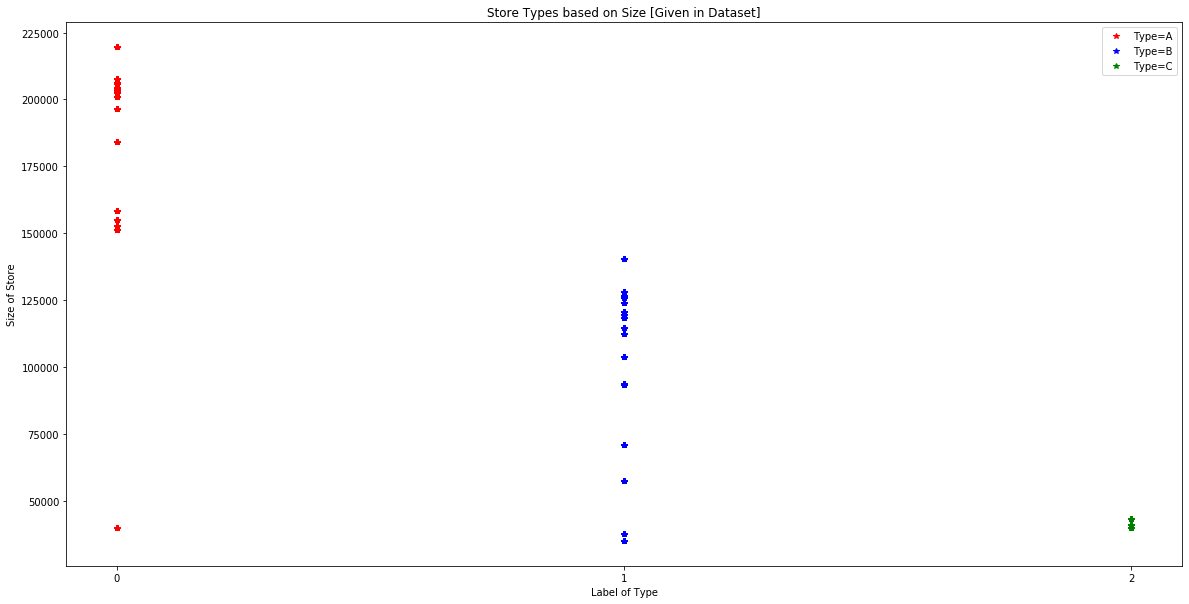

In [41]:
fig, ax= plt.subplots(figsize=(20,10))
ax.set_xticks([0,1,2])

plt.plot(yc[yc == 0], walmart[walmart['Type'] == 'A']['Size'],'*', color='red', label ='Type=A')
plt.plot(yc[yc == 1], walmart[walmart['Type'] == 'B']['Size'], '*', color='blue', label ='Type=B')
plt.plot(yc[yc == 2], walmart[walmart['Type'] == 'C']['Size'], '*', color='green', label ='Type=C')

plt.ylabel('Size of Store')
plt.xlabel('Label of Type')
plt.title('Store Types based on Size [Given in Dataset]')
plt.legend()

plt.show()

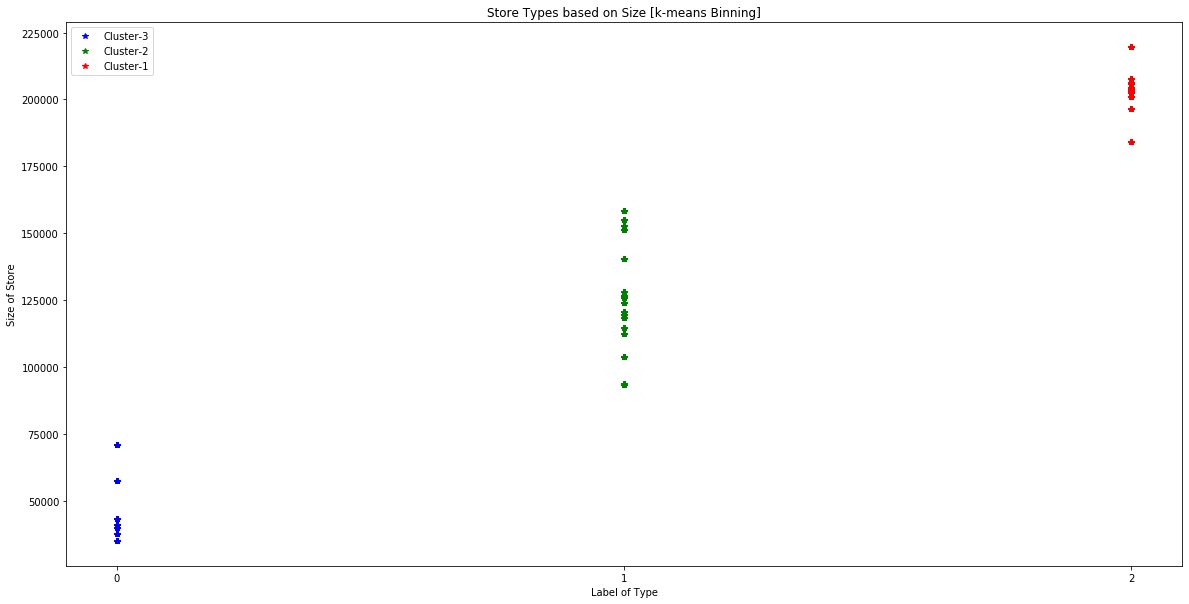

In [42]:
fig, ax= plt.subplots(figsize=(20,10))
ax.set_xticks([0,1,2])

plt.plot(walmart[walmart['size_bucket_kmean'] == 0]['size_bucket_kmean'], walmart[walmart['size_bucket_kmean'] == 0]['Size'],'*', color='blue', label ='Cluster-3')
plt.plot(walmart[walmart['size_bucket_kmean'] == 1]['size_bucket_kmean'], walmart[walmart['size_bucket_kmean'] == 1]['Size'], '*', color='green', label ='Cluster-2')
plt.plot(walmart[walmart['size_bucket_kmean'] == 2]['size_bucket_kmean'], walmart[walmart['size_bucket_kmean'] == 2]['Size'], '*', color='red', label ='Cluster-1')

plt.ylabel('Size of Store')
plt.xlabel('Label of Type')
plt.title('Store Types based on Size [k-means Binning]')
plt.legend()

plt.show()

- The clusters that we obtained via kmeans clustering and kmeans based discretization are same
- The Type of group in given datset is not solely on size as can be seen 

<a class="anchor" id ="clust_2d"></a>

## GOAL-2: cluster stores based on store sizes and weekly_sales 

- Both store size and weekly_sales are continous variables and on different scales so will normalize them  

Reference Links: 
- https://community.alteryx.com/t5/Alteryx-Designer-Knowledge-Base/Standardization-in-Cluster-Analysis/ta-p/302296
- http://varianceexplained.org/r/kmeans-free-lunch/
- https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
-
 


In [43]:

X2d = walmart[['Size', 'Weekly_Sales']]
y2d = walmart['Type']


#Following approach is same as Label Encoding 
# kmeans gives clusters as 0 to k numbers 
y2d = np.select([data['Type'] == 'A',  
               data['Type'] == 'B', 
               data['Type'] == 'C'], [0,1,2])
X2d.head()

,Size,Weekly_Sales
0,151315.0,46039.49
1,151315.0,41595.55
2,151315.0,19403.54
3,151315.0,21827.90
4,151315.0,21043.39


In [44]:
X2d.corr(method='spearman')

,Size,Weekly_Sales
Size,1.000000,0.289975
Weekly_Sales,0.289975,1.000000


<a class="anchor" id ="clust_2d_kmeans_no_norm"></a>
### Kmeans Clustering Without Normalization  

In [45]:
from sklearn.cluster import KMeans

In [46]:
%timeit 

wcss = []

for i in range(1,15):
    kmeans= KMeans(n_clusters = i, init='k-means++', random_state = 0)
    kmeans.fit(X2d)
    wcss.append(kmeans.inertia_)

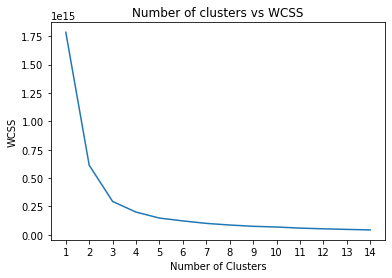

In [47]:
fig, ax = plt.subplots()
ax.set_xticks(range(1,15))

sns.lineplot(x= range(1,15), y = wcss)

plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Number of clusters vs WCSS')
plt.show()

Now lets fit kmeans with n_clusters = 4

In [48]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
y_pred_kmeans = kmeans.fit_predict(X2d)

np.unique(y_pred_kmeans)

array([0, 1, 2, 3], dtype=int32)

/Users/adeela/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


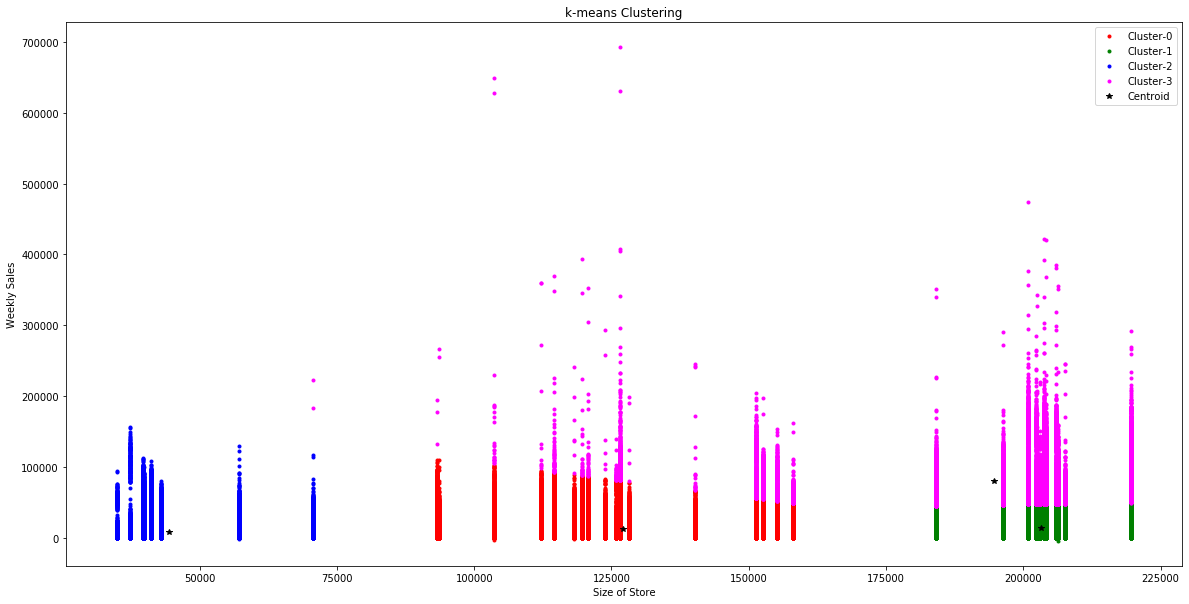

In [49]:
plt.figure(figsize=(20,10))

plt.plot(X2d[y_pred_kmeans== 0]['Size'], X2d[y_pred_kmeans== 0]['Weekly_Sales'], '.', color ='red', label ='Cluster-0')
plt.plot(X2d[y_pred_kmeans== 1]['Size'], X2d[y_pred_kmeans== 1]['Weekly_Sales'], '.', color ='green', label ='Cluster-1')
plt.plot(X2d[y_pred_kmeans== 2]['Size'], X2d[y_pred_kmeans== 2]['Weekly_Sales'], '.', color ='blue', label ='Cluster-2')
plt.plot(X2d[y_pred_kmeans== 3]['Size'], X2d[y_pred_kmeans== 3]['Weekly_Sales'], '.', color ='magenta', label ='Cluster-3')

plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], '*', color='black', label='Centroid')

plt.xlabel('Size of Store')
plt.ylabel('Weekly Sales')
plt.title('k-means Clustering')
plt.legend()

plt.show()

In [50]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
y_pred_kmeans = kmeans.fit_predict(X2d)

np.unique(y_pred_kmeans)

array([0, 1, 2], dtype=int32)

/Users/adeela/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


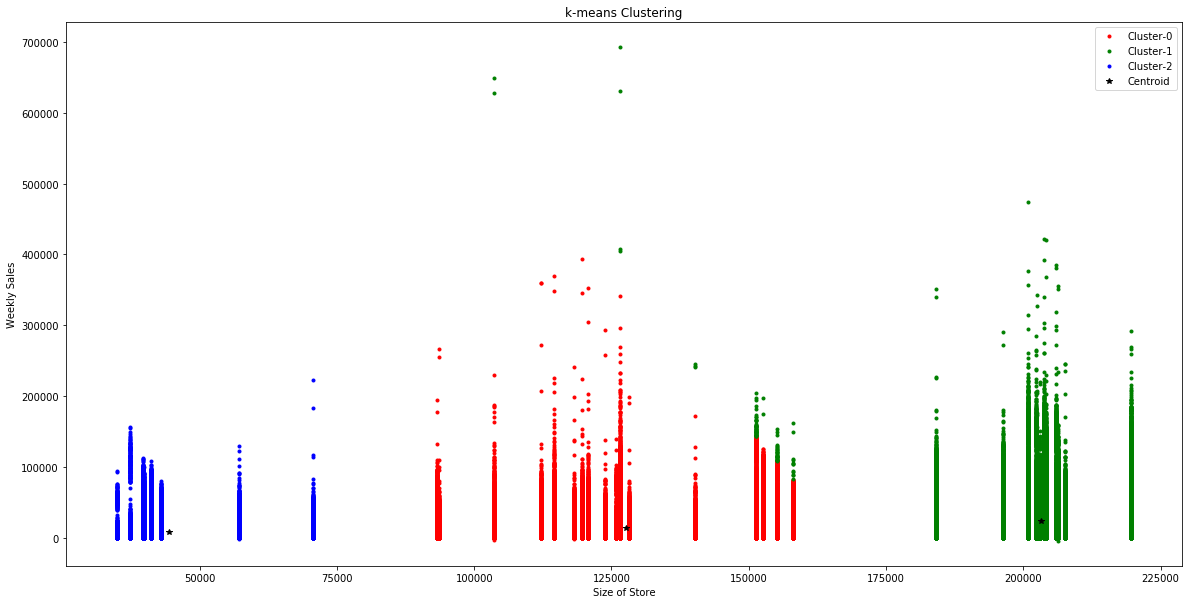

In [51]:
plt.figure(figsize=(20,10))

plt.plot(X2d[y_pred_kmeans== 0]['Size'], X2d[y_pred_kmeans== 0]['Weekly_Sales'], '.', color ='red', label ='Cluster-0')
plt.plot(X2d[y_pred_kmeans== 1]['Size'], X2d[y_pred_kmeans== 1]['Weekly_Sales'], '.', color ='green', label ='Cluster-1')
plt.plot(X2d[y_pred_kmeans== 2]['Size'], X2d[y_pred_kmeans== 2]['Weekly_Sales'], '.', color ='blue', label ='Cluster-2')

plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], '*', color='black', label='Centroid')

plt.xlabel('Size of Store')
plt.ylabel('Weekly Sales')
plt.title('k-means Clustering')
plt.legend()

plt.show()

**Interpretation** :

- It looks Weekly_sales has no meaningful impact on clustering. The 
- stores are divided into groups based on the size of the store 

<a class="anchor" id ="clust_2d_kmeans_norm"></a>
### Kmeans Clustering With Normalization 

In [52]:
from sklearn.preprocessing import StandardScaler 

In [53]:
#scale data
sc = StandardScaler()
X2d_n = sc.fit_transform(X2d)

X2d_n

array([[ 0.23920828,  1.32349911],
       [ 0.23920828,  1.12782742],
       [ 0.23920828,  0.15068819],
       ...,
       [-0.30348851, -0.65695365],
       [-0.30348851, -0.67020746],
       [-0.30348851, -0.65625884]])

In [54]:
X2d_n.shape

(421568, 2)

### Find approximate numer of clusters to use:

In [55]:
wcss = []

for i in range(1,15):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state = 0)
    kmeans.fit(X2d_n)
    wcss.append(kmeans.inertia_)
    

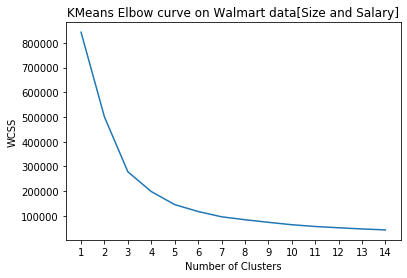

In [56]:
fig, ax = plt.subplots()
ax.set_xticks(range(1,15))

plt.plot(range(1,15), wcss)

plt.title('KMeans Elbow curve on Walmart data[Size and Salary]')
plt.ylabel('WCSS')
plt.xlabel('Number of Clusters')

plt.show()

Elbow is at k=6 

Now lets try to build clusters by specifying the value of k 

In [57]:
kmeans = KMeans(n_clusters=6, 
       init='k-means++', 
       random_state=0, 
       verbose =0)

y2d_n_kmeans = kmeans.fit_predict(X2d_n)


In [58]:
np.unique(y2d_n_kmeans)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [59]:
kmeans.cluster_centers_.shape

(6, 2)

/Users/adeela/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


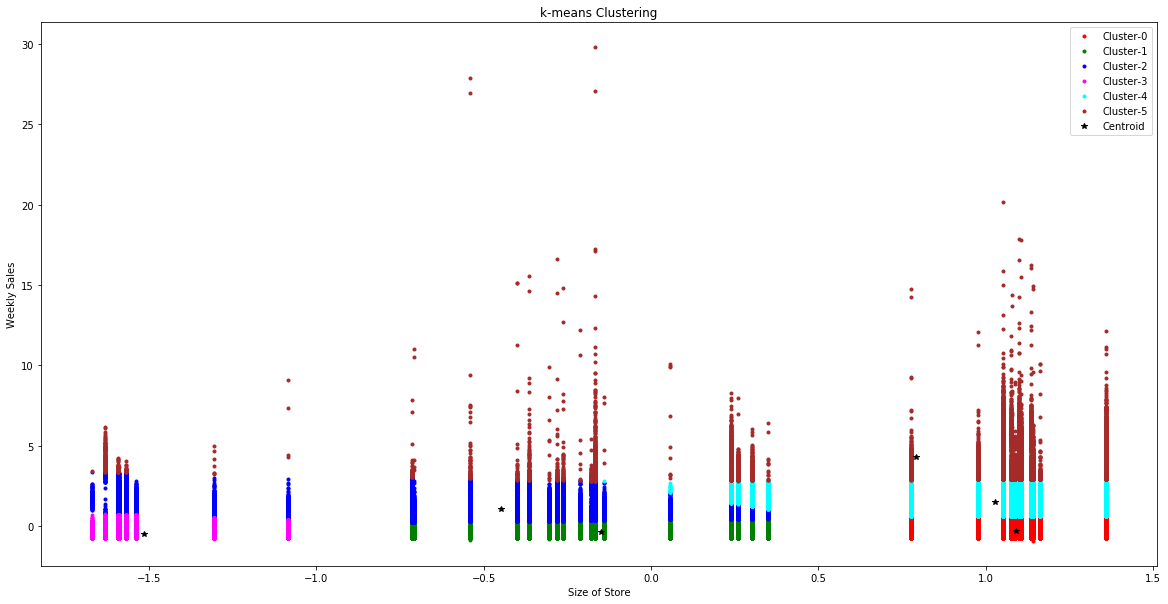

In [60]:
#plt.scatter() takes forever thats why using plt.plot()
plt.figure(figsize=(20,10))

plt.plot(X2d_n[y2d_n_kmeans== 0][:, 0], X2d_n[y2d_n_kmeans== 0][:, 1], '.', color ='red', label ='Cluster-0')
plt.plot(X2d_n[y2d_n_kmeans== 1][:, 0], X2d_n[y2d_n_kmeans== 1][:, 1], '.', color ='green', label ='Cluster-1')
plt.plot(X2d_n[y2d_n_kmeans== 2][:, 0], X2d_n[y2d_n_kmeans== 2][:, 1], '.', color ='blue', label ='Cluster-2')
plt.plot(X2d_n[y2d_n_kmeans== 3][:, 0], X2d_n[y2d_n_kmeans== 3][:, 1], '.', color ='magenta', label ='Cluster-3')
plt.plot(X2d_n[y2d_n_kmeans== 4][:, 0], X2d_n[y2d_n_kmeans== 4][:, 1], '.', color ='cyan', label ='Cluster-4')
plt.plot(X2d_n[y2d_n_kmeans== 5][:, 0], X2d_n[y2d_n_kmeans== 5][:, 1], '.', color ='brown', label ='Cluster-5')

plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], '*', color='black', label='Centroid')

plt.xlabel('Size of Store')
plt.ylabel('Weekly Sales')
plt.title('k-means Clustering')
plt.legend()

plt.show()

Now Lets build 3 clusters on 2D data to see if they match with actual clusters (Store Type) in the dataset

In [61]:
kmeans_3 = KMeans(n_clusters=3, 
       init='k-means++', 
       random_state=0)

y2d_n_kmeans_3 = kmeans_3.fit_predict(X2d_n)

/Users/adeela/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


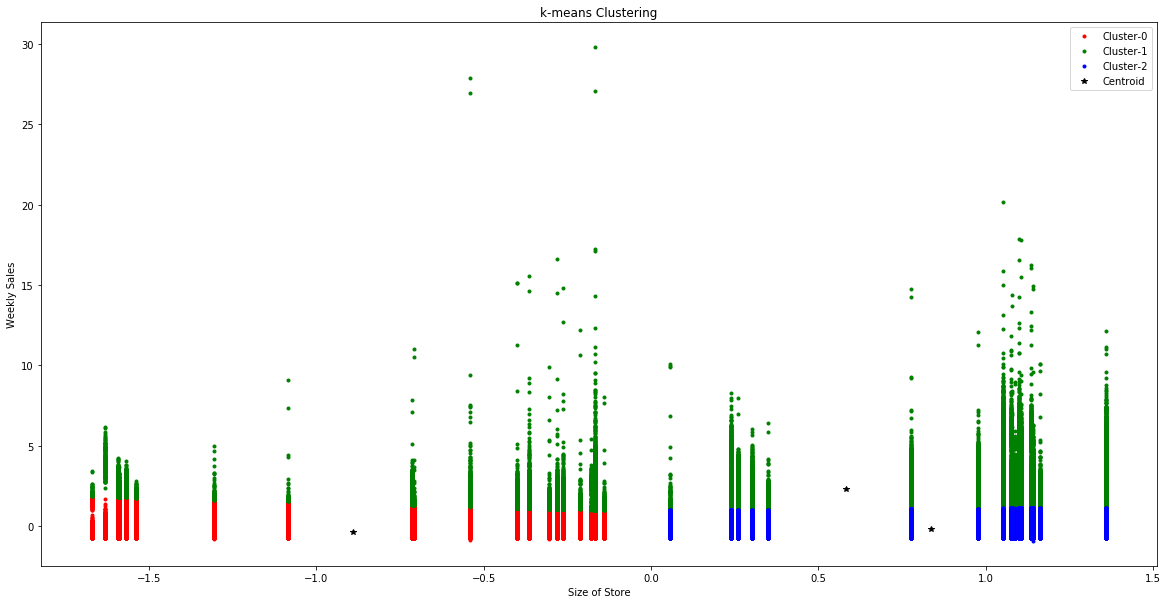

In [62]:
plt.figure(figsize=(20,10))

plt.plot(X2d_n[y2d_n_kmeans_3 == 0][:, 0], X2d_n[y2d_n_kmeans_3 == 0][:, 1], '.', color ='red', label ='Cluster-0')
plt.plot(X2d_n[y2d_n_kmeans_3 == 1][:, 0], X2d_n[y2d_n_kmeans_3 == 1][:, 1], '.', color ='green', label ='Cluster-1')
plt.plot(X2d_n[y2d_n_kmeans_3 == 2][:, 0], X2d_n[y2d_n_kmeans_3 == 2][:, 1], '.', color ='blue', label ='Cluster-2')

plt.plot(kmeans_3.cluster_centers_[:,0], kmeans_3.cluster_centers_[:,1], '*', color='black', label='Centroid')

plt.xlabel('Size of Store')
plt.ylabel('Weekly Sales')
plt.title('k-means Clustering')
plt.legend()

plt.show()

**Interpretation**: 

- With Normalization, Now 'weekly sales' does play a role in determing the cluster.
- If 'weekly_sales' ae higher than 2.5 (sacled value) then all stores belong to one cluster-1 regarless of size of store 
- If 'weekly_sales' ae higher lower than 2.5 (sacled value) and store 'size' is less than 0.0 (scaled value) then all stores belong to one cluster-0 
- If 'weekly_sales' ae higher lower than 2.5 (sacled value) and store 'size' is greater than 0.0 (scaled value) then all stores belong to one cluster-2 


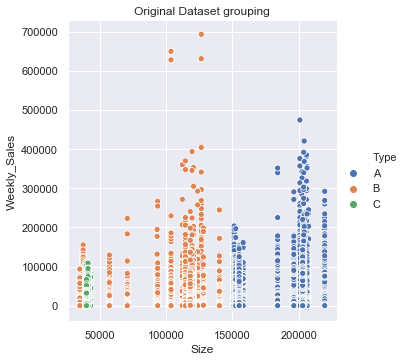

In [63]:
sns.set(rc={'figure.figsize':(20,20)})

sns.relplot(data =walmart, x='Size', y ='Weekly_Sales', hue='Type')
plt.title('Original Dataset grouping')
plt.show()

- Grouping of stores 'store Type' in original data and after clustering is very different for clusters on normalized data
- Though clusters in origibal data and on non-normalized data have some similarity as they both don't seem to depend on 'weekly_sales'
    

<a class="anchor" id ="clust_2d_agglomerative"></a>
### Hierarchical/Agglomerative Clustering 
- To find the optimal number of clusters we first create a dendrogram 


In [64]:
import scipy.cluster.hierarchy as sch

In [65]:
# kernel dies as this step is computationally expensive 
#plt.figure(figsize=(20,10))

#sch.dendrogram(sch.linkage(X2d, method='ward'))
               

In [66]:
from sklearn.cluster import AgglomerativeClustering

In [67]:
hc = AgglomerativeClustering(n_clusters =3, affinity='euclidean', linkage='ward')

In [68]:
#unable to perform this step as kernel keeps dying 
#y_hc = hc.fit_predict(X2d_n)

<a class="anchor" id ="clust_nd"></a>
## GOAL-3: cluster stores based on all varaibles (numerical + categorical) and see how it is different than actual Store Types 

Recommendation:

- If you have binary values, discrete attributes or categorial attributes, stay away from k-means. K-means needs to compute means, and the mean value is not meaningful on categorical data.
- 
- 


Reference Links:
- https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data


In [69]:
walmart = pd.read_pickle('dataset/walmart/data.pkl')
walmart.head()

,month,quarter,is_weekend,day_name,IsHoliday,Size,Type,Weekly_Sales
0,12,4,0,Thursday,True,151315.0,A,46039.49
1,2,1,0,Friday,False,151315.0,A,41595.55
2,2,1,0,Friday,False,151315.0,A,19403.54
3,5,2,0,Monday,False,151315.0,A,21827.90
4,12,4,0,Friday,False,151315.0,A,21043.39


In [70]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421568 entries, 0 to 421567
Data columns (total 8 columns):
month           421568 non-null category
quarter         421568 non-null category
is_weekend      421568 non-null category
day_name        421568 non-null category
IsHoliday       421568 non-null category
Size            421568 non-null float64
Type            421568 non-null category
Weekly_Sales    421568 non-null float64
dtypes: category(6), float64(2)
memory usage: 12.1 MB


In [71]:
walmart.rename(columns={"is_weekend": "isWeekend"}, inplace=True)
walmart.head(1)

,month,quarter,isWeekend,day_name,IsHoliday,Size,Type,Weekly_Sales
0,12,4,0,Thursday,True,151315.0,A,46039.49


<a class="anchor" id ="clust_nd_dummies"></a>
### Data Dummification

In [72]:
cat_cols = walmart.select_dtypes('category').columns.to_list()
cat_cols

['month', 'quarter', 'isWeekend', 'day_name', 'IsHoliday', 'Type']

In [73]:
'''
    Everytime we execute command get_dummies(), new labels are assigned. we dont need to do this step every time. 
    So once data is dummified , I am saving it at location: dataset/walmart/dummified_data_all.pkl for later use.
    
    For now code is commented and left her for reference.
'''
#data = walmart
#for cat in cat_cols: 
#    if cat not in ['month']:
#        df = pd.get_dummies(walmart[cat])
#        #print(cat, df.columns)
#        data = pd.merge(data, df, right_index=True, left_index=True)

#data.info()    

'\n    Everytime we execute command get_dummies(), new labels are assigned. we dont need to do this step every time. \n    So once data is dummified , I am saving it at location: dataset/walmart/dummified_data_all.pkl for later use.\n    \n    For now code is commented and left her for reference.\n'

In [74]:
#data.rename(columns = {'A':'Type_A',
#             'B':'Type_B', 
#             'C':'Type_C', 
#             'True_x': 'is_holiday', 
#             'False_x': 'is_not_holiday', 
#             '0_y': 'is_not_weekend', 
#             '1_y': 'is_weekend', 
#             1: 'quarter_1', 
#             2: 'quarter_2', 
#             3: 'quarter_3', 
#             4: 'quarter_4' }, inplace=True)

#data.head()

In [75]:
#dummify month column

#temp_df = pd.get_dummies(walmart['month'])
#temp_df.rename(columns={1: 'Jan',
#             2: 'Feb',
#             3: 'March',
#             4: 'April',
#             5 : 'May',
#             6 : 'June',
#             7 : 'July',
#             8 : 'August',
#             9  : 'September', 
#             10 : 'October',
#             11 : 'November',
#             12 : 'Dec' }, inplace =True)

#temp_df.head()

In [76]:
#data = pd.merge(data, temp_df, right_index=True, left_index=True)
#data.info()

In [77]:
#save for later
#pd.to_pickle(data, 'dataset/walmart/dummified_data_all.pkl')

<a class="anchor" id ="clust_nd_data_clustering"></a>
### Data for Clustering 

In [78]:
data = pd.read_pickle('dataset/walmart/dummified_data_all.pkl')

In [79]:
data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'day_name', 'isWeekend', 'quarter', 'month', 'is_not_holiday',
       'is_holiday', 'Type_A', 'Type_B', 'Type_C', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'is_not_weekend', 'is_weekend', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4', 'Jan', 'Feb', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'Dec'],
      dtype='object')

In [80]:
nd_clust_data = data[['Type', 'Size', 'Weekly_Sales', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4', 'is_not_weekend', 'is_weekend', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'is_not_holiday', 'is_holiday', 'Jan','Feb', 'March', 'April', 'May', 'June', 
       'July', 'August', 'September','October', 'November', 'Dec']]

nd_clust_data.describe()

,Size,Weekly_Sales,quarter_1,quarter_2,quarter_3,quarter_4,is_not_weekend,is_weekend,Friday,Monday,...,March,April,May,June,July,August,September,October,November,Dec
count,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,...,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000,421568.000000
mean,136727.925037,15981.229443,0.231000,0.272428,0.265106,0.231467,0.895336,0.104664,0.671263,0.077432,...,0.083991,0.097887,0.090645,0.083896,0.090431,0.083588,0.091086,0.090930,0.063062,0.077475
std,60980.717180,22711.232698,0.421473,0.445210,0.441390,0.421770,0.306120,0.306120,0.469755,0.267277,...,0.277375,0.297162,0.287104,0.277233,0.286799,0.276769,0.287732,0.287509,0.243075,0.267344
min,34875.000000,-4988.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93638.000000,2079.632500,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,140167.000000,7612.020000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,202505.000000,20205.837500,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,219622.000000,693099.360000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
nd_clust_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421568 entries, 0 to 421567
Data columns (total 30 columns):
Type              421568 non-null category
Size              421568 non-null float64
Weekly_Sales      421568 non-null float64
quarter_1         421568 non-null uint8
quarter_2         421568 non-null uint8
quarter_3         421568 non-null uint8
quarter_4         421568 non-null uint8
is_not_weekend    421568 non-null uint8
is_weekend        421568 non-null uint8
Friday            421568 non-null uint8
Monday            421568 non-null uint8
Saturday          421568 non-null uint8
Sunday            421568 non-null uint8
Thursday          421568 non-null uint8
Tuesday           421568 non-null uint8
Wednesday         421568 non-null uint8
is_not_holiday    421568 non-null uint8
is_holiday        421568 non-null uint8
Jan               421568 non-null uint8
Feb               421568 non-null uint8
March             421568 non-null uint8
April             421568 non-null uint8
Ma

In [82]:
nd_clust_data.head()

,Type,Size,Weekly_Sales,quarter_1,quarter_2,quarter_3,quarter_4,is_not_weekend,is_weekend,Friday,...,March,April,May,June,July,August,September,October,November,Dec
0,A,151315.0,46039.49,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,A,151315.0,41595.55,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A,151315.0,19403.54,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A,151315.0,21827.90,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,A,151315.0,21043.39,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1


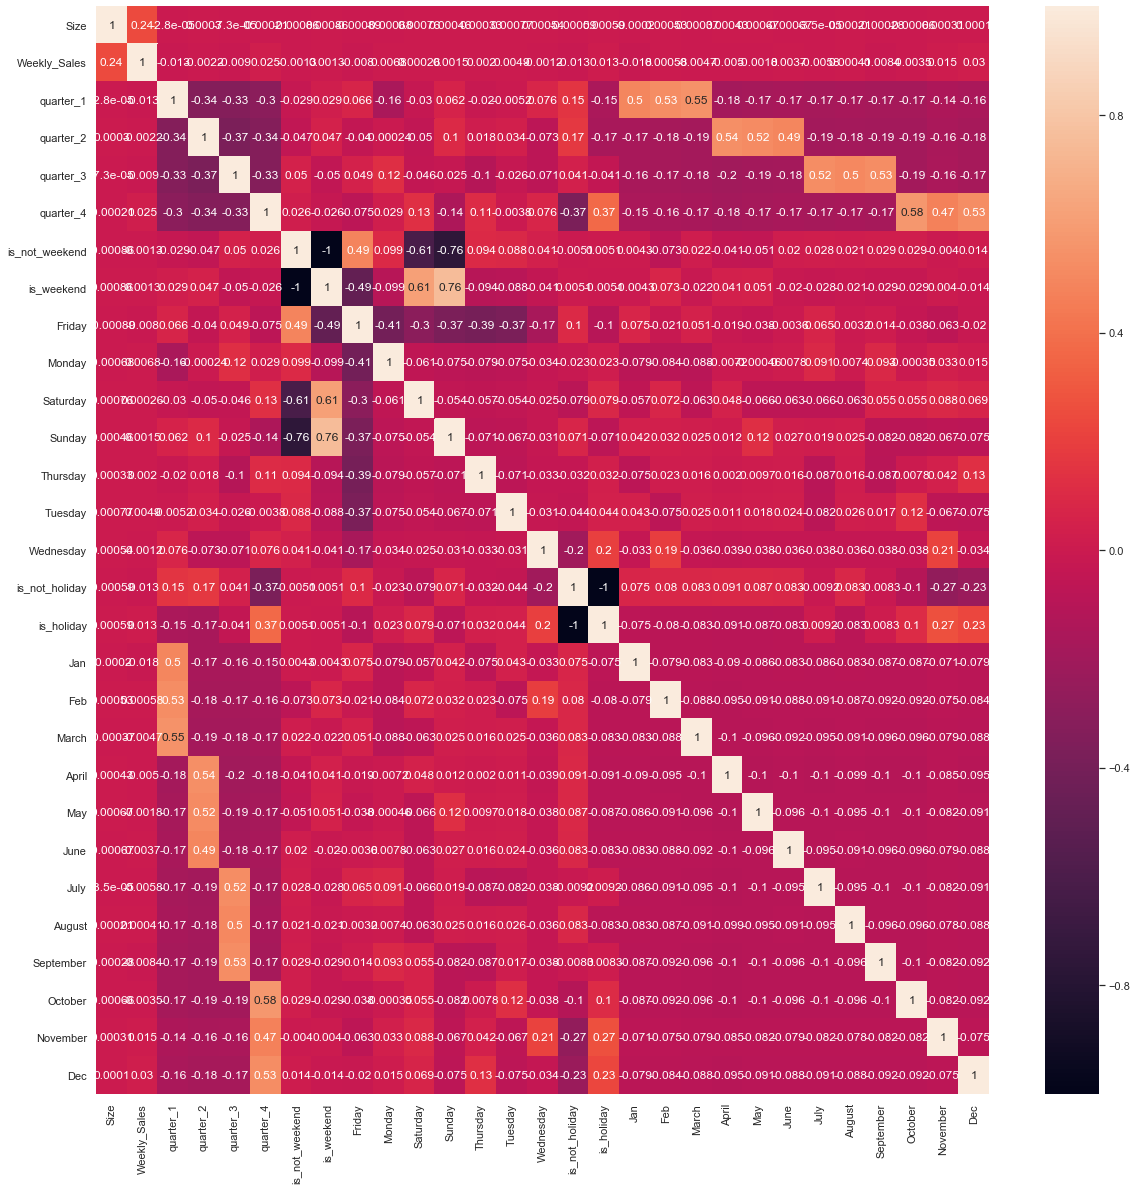

In [83]:
sns.heatmap(nd_clust_data.corr(), annot=True)

<a class="anchor" id ="clust_nd_kmeans_no_norm"></a>
### Kmeans Clustering w/o Normalization 


In [84]:
Xnd = nd_clust_data.iloc[:, 1:]
ynd = nd_clust_data['Type']

Xnd.head(2)

,Size,Weekly_Sales,quarter_1,quarter_2,quarter_3,quarter_4,is_not_weekend,is_weekend,Friday,Monday,...,March,April,May,June,July,August,September,October,November,Dec
0,151315.0,46039.49,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,151315.0,41595.55,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
from sklearn.cluster import KMeans

<a class="anchor" id ="clust_nd_kmeans_no_norm_elbow"></a>
#### Optimal Number of clusters using Elbow curve

In [86]:
wcss_nd = []

for i in range(1,10):
    kmeans_nd = KMeans(n_clusters = i, init='k-means++', random_state = 0)
    kmeans_nd.fit(Xnd)
    wcss_nd.append(kmeans_nd.inertia_)    
    

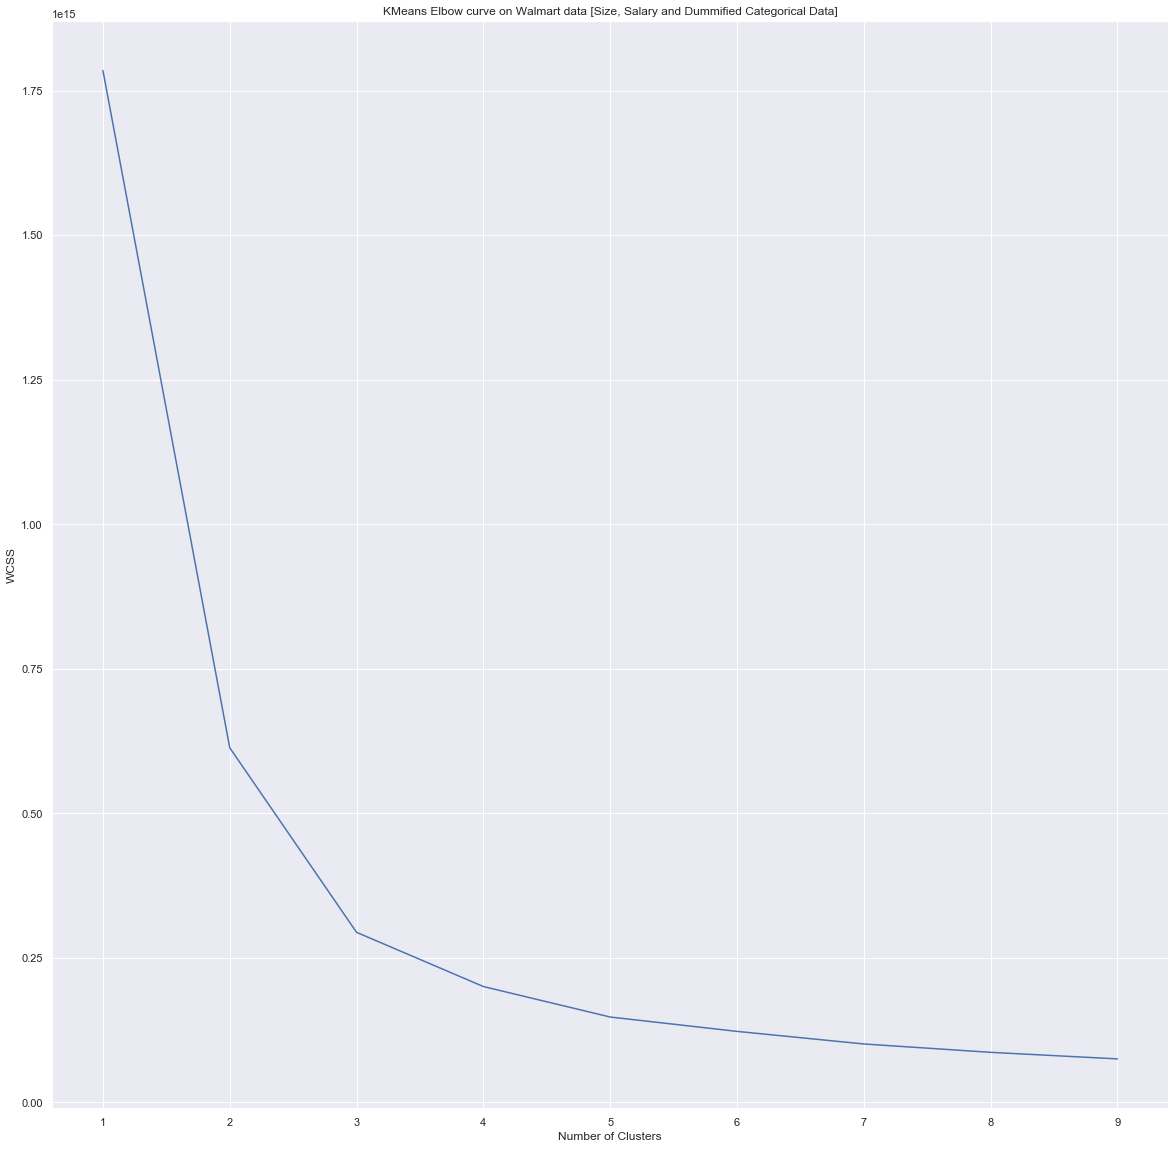

In [87]:
# plot results 

plt.plot(range(1,10), wcss_nd)

plt.title('KMeans Elbow curve on Walmart data [Size, Salary and Dummified Categorical Data]')
plt.ylabel('WCSS')
plt.xlabel('Number of Clusters')

plt.show()

In [88]:
# Let's do clustering with 4 clusters 

kmeans_nd = KMeans(n_clusters = 4, init='k-means++', random_state = 0)
y_nd_label= kmeans_nd.fit_predict(Xnd)   

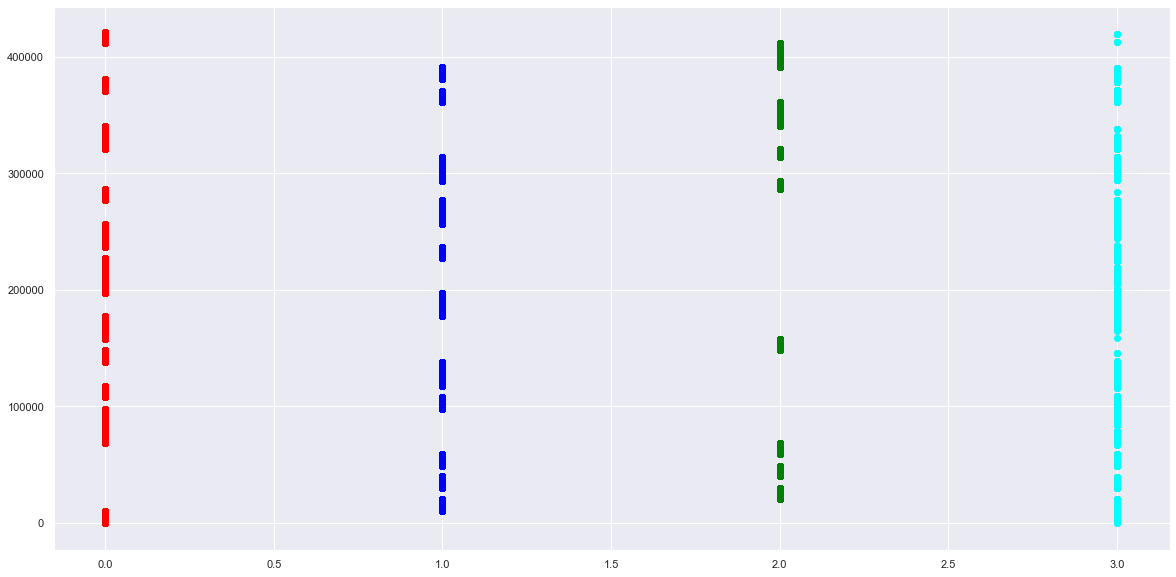

In [89]:
plt.figure(figsize=(20,10))
plt.scatter(y_nd_label[y_nd_label == 0], Xnd.index[y_nd_label == 0], color='red', label='Cluster-0')
plt.scatter(y_nd_label[y_nd_label == 1], Xnd.index[y_nd_label == 1], color='blue', label='Cluster-1')
plt.scatter(y_nd_label[y_nd_label == 2], Xnd.index[y_nd_label == 2], color='green', label='Cluster-2')
plt.scatter(y_nd_label[y_nd_label == 3], Xnd.index[y_nd_label == 3], color='cyan', label='Cluster-3')
#plt.scatter(kmeans_nd.cluster_centers_[:0], kmeans_nd.cluster_centers_[:1], '*', color='black', label='Centroid')

#plt.legend()

plt.show()

<a class="anchor" id ="clust_nd_kmeans_no_norm_3"></a>
#### kmeans with 3 clusters 

In [90]:
# Let's do clustering with 3 clusters and compare results with original categotization

kmeans_nd = KMeans(n_clusters = 3, init='k-means++', random_state = 0)
y_nd_label= kmeans_nd.fit_predict(Xnd)  

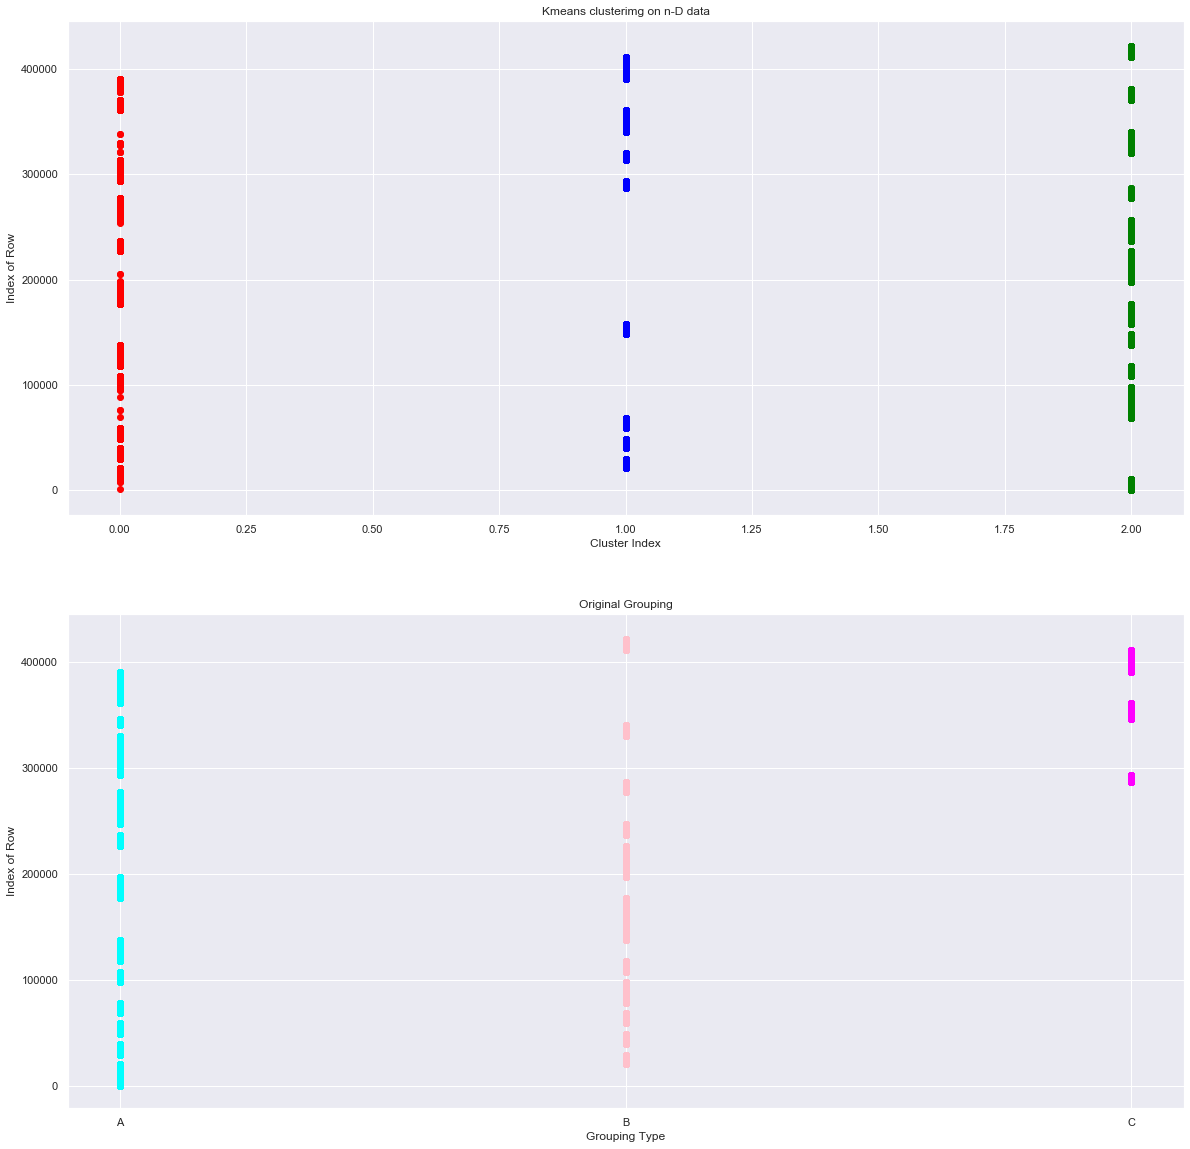

In [91]:
#plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)

#fig, ax= plt.subplots()
#ax.set_xticks([0,1,2])

plt.scatter(y_nd_label[y_nd_label == 0], Xnd.index[y_nd_label == 0], color='red', label='Cluster-0')
plt.scatter(y_nd_label[y_nd_label == 1], Xnd.index[y_nd_label == 1], color='blue', label='Cluster-1')
plt.scatter(y_nd_label[y_nd_label == 2], Xnd.index[y_nd_label == 2], color='green', label='Cluster-2')
plt.ylabel('Index of Row')
plt.xlabel('Cluster Index')
plt.title('Kmeans clusterimg on n-D data')

plt.subplot(2, 1, 2)

plt.scatter(ynd[ynd == 'A'], nd_clust_data[ynd == 'A'].index, color='cyan', label='A')
plt.scatter(ynd[ynd == 'B'], nd_clust_data[ynd == 'B'].index, color='pink', label='B')
plt.scatter(ynd[ynd == 'C'], nd_clust_data[ynd == 'C'].index, color='magenta', label='C')

plt.ylabel('Index of Row')
plt.xlabel('Grouping Type')
plt.title('Original Grouping')

plt.show()

The kmeans clusters and original data differ vary much especially for Type 'C'


<a class="anchor" id ="clust_nd_kmeans_no_norm_analysis"></a>
#### Analysis of Results 

<font color='red'> Can we see why kmeans results are this way ? </font>

In [92]:
data.select_dtypes('category').columns

Index(['IsHoliday', 'Type', 'day_name', 'isWeekend', 'quarter', 'month'], dtype='object')

In [93]:
data[y_nd_label == 0].groupby(['quarter', 'month', 'day_name', 'isWeekend', 'IsHoliday'])['Weekly_Sales'].agg({'count', 'min', 'max'})

count        max      min
quarter month day_name  isWeekend IsHoliday                           
1       1     Friday    0         False       8496  197649.89  -778.50
              Sunday    1         False       1060  174219.51  -103.00
              Tuesday   0         False       1071  175473.67   -53.20
        2     Friday    0         False       7505  205250.96  -149.00
              Saturday  1         False       1072  172338.47     1.07
              Sunday    1         False       1062  198349.17     0.02
              Thursday  0         False       1075  203457.42    -9.96
              Wednesday 0         False       1072  164320.09   -15.00
        3     Friday    0         False       9609  198551.21 -1321.48
              Sunday    1         False       1063  162995.08   -45.84
              Thursday  0         False       1068  171598.20     0.10
              Tuesday   0         False       1064  198704.92  -157.63
2       4     Friday    0         False       9623  191840.95  -698.00
              Monday    0         False       1064  208504.83   -42.78
              Saturday  1         False       1062  207824.62  -219.00
              Sunday    1         False       1076  200367.18   -37.24
              Thursday  0         False       1077  200789.85   -69.56
              Tuesday   0         False       1056  190128.43   -90.00
        5     Friday    0         False       8509  187738.85  -279.00
              Monday    0         False       1076  214383.07   -59.00
              Sunday    1         False       2138  293966.05   -59.00
              Thursday  0         False       1075  192860.85   -39.50
              Tuesday   0         False       1059  206935.29   -97.97
        6     Friday    0         False       8512  206871.52  -594.00
              Monday    0         False       1076  224917.94   -15.48
              Sunday    1         False       1076  196628.33   -41.42
              Thursday  0         False       1069  185215.02   -28.00
              Tuesday   0         False       1056  204695.13   -32.00
3       7     Friday    0         False      10597  198789.07 -1098.00
              Monday    0         False       1071  206160.36   -39.00
                                  True        1073  190579.72  -176.40
              Sunday    1         False       1066  221834.28  -298.00
        8     Friday    0         False       8527  241120.00  -649.00
              Monday    0         False       1074  206575.90   -78.00
              Sunday    1         False       1054  188688.12    -2.66
              Thursday  0         False       1068  206017.23  -198.00
              Tuesday   0         False       1061  210596.66 -4988.94
        9     Friday    0         False       8524  186759.11  -898.00
                                  True        1081  214448.96    -5.00
              Monday    0         False       2162  227088.13  -159.00
              Saturday  1         False       1073  180584.36  -118.00
              Tuesday   0         False       1054  191981.99   -78.00
4       10    Friday    0         False       8484  187911.15 -1098.00
              Monday    0         False       1070  194032.48  -103.06
              Saturday  1         True        1070  205314.67  -598.00
              Thursday  0         False       1061  190737.26   -10.54
              Tuesday   0         False       1069  221013.44   -24.00
                                  True        1088  213557.23   -14.88
        11    Friday    0         False       3201  206465.15 -1098.00
                                  True        2170  693099.36  -159.00
              Monday    0         False       1076  194034.68   -69.88
              Saturday  1         False       1057  194723.71   -13.00
              Thursday  0         False       1081  191167.30  -250.08
              Wednesday 0         True        1065  195482.73     0.75
        12    Friday    0         False       5403  406988.63  -649.0

In [94]:
data[y_nd_label == 1].groupby(['quarter', 'month', 'day_name', 'isWeekend', 'IsHoliday'])['Weekly_Sales'].agg({'count', 'min', 'max'})

count        max      min
quarter month day_name  isWeekend IsHoliday                           
1       1     Friday    0         False       5162  134385.14  -133.56
              Sunday    1         False        645  128664.34    -5.98
              Tuesday   0         False        650  132300.71     0.00
        2     Friday    0         False       4547  144088.08  -149.88
              Saturday  1         False        665  124296.12    -6.94
              Sunday    1         False        624  134152.28     1.00
              Thursday  0         False        635  138917.47   -13.00
              Wednesday 0         False        643  106769.36   -43.00
        3     Friday    0         False       5863  155232.85   -59.96
              Sunday    1         False        633  103783.60    -5.00
              Thursday  0         False        663   86564.24   -38.88
              Tuesday   0         False        637  134972.67   -64.38
2       4     Friday    0         False       5834  124003.49  -199.95
              Monday    0         False        653  125600.76   -60.00
              Saturday  1         False        636  131623.64   -15.00
              Sunday    1         False        647  142476.27   -60.00
              Thursday  0         False        647  106252.70    -9.12
              Tuesday   0         False        627  116867.62    -3.58
        5     Friday    0         False       5139  127967.57  -379.00
              Monday    0         False        630  148427.67    -6.88
              Sunday    1         False       1277  155897.94   -12.99
              Thursday  0         False        664   99091.97   -16.88
              Tuesday   0         False        638  138137.99     0.50
        6     Friday    0         False       5187  121083.31   -43.48
              Monday    0         False        662  116958.54   -17.88
              Sunday    1         False        660  125369.20   -10.97
              Thursday  0         False        662   93702.39   -24.00
              Tuesday   0         False        632  140753.31   -17.00
3       7     Friday    0         False       6432  137923.62  -590.04
              Monday    0         False        630  126019.88   -58.00
                                  True         659   98189.06   -30.92
              Sunday    1         False        651  109972.31   -10.38
        8     Friday    0         False       5143  126376.18  -419.28
              Monday    0         False        660  102091.86   -24.97
              Sunday    1         False        647  108614.93   -11.54
              Thursday  0         False        652  112366.88   -73.74
              Tuesday   0         False        642  134171.12    -9.96
        9     Friday    0         False       5202  129568.46 -1008.96
                                  True         646  107423.91  -486.27
              Monday    0         False       1334  110003.37 -1699.00
              Saturday  1         False        636  145589.34   -15.86
              Tuesday   0         False        628  110607.17    -1.50
4       10    Friday    0         False       5199  123508.09  -124.00
              Monday    0         False        661   92905.50    -5.97
              Saturday  1         True         636  128050.04   -23.10
              Thursday  0         False        637  102739.10    -9.53
              Tuesday   0         False        641  126992.56  -153.12
                                  True         666  110379.12    -8.00
        11    Friday    0         False       1935  112152.35  -101.26
                                  True        1308  222921.09  -169.98
              Monday    0         False        658  101637.86   -79.98
              Saturday  1         False        637  112798.96   -15.00
              Thursday  0         False        650  127654.09   -27.71
              Wednesday 0         True         637  129054.64  -500.00
        12    Friday    0         False       3274  123961.89  -372.9

In [95]:
data[y_nd_label == 2].groupby(['quarter', 'month', 'day_name', 'isWeekend', 'IsHoliday'])['Weekly_Sales'].agg({'count', 'min', 'max'})

count        max      min
quarter month day_name  isWeekend IsHoliday                           
1       1     Friday    0         False       9858  157727.81  -543.00
              Sunday    1         False       1230  118966.90   -17.00
              Tuesday   0         False       1230  120085.83  -399.00
        2     Friday    0         False       8711  207773.40 -1750.00
              Saturday  1         False       1257  156039.04   -45.25
              Sunday    1         False       1231  124821.44  -175.54
              Thursday  0         False       1239  131853.01  -224.00
              Wednesday 0         False       1234  139659.53 -3924.00
        3     Friday    0         False      11121  218559.54  -548.14
              Sunday    1         False       1226  135260.49    -9.00
              Thursday  0         False       1236  134832.22   -99.87
              Tuesday   0         False       1225  130199.04  -173.84
2       4     Friday    0         False      11106  135336.32  -224.00
              Monday    0         False       1237  164085.50  -179.00
              Saturday  1         False       1228  198883.53   -81.00
              Sunday    1         False       1235  175471.97   -41.02
              Thursday  0         False       1231  140937.93   -43.95
              Tuesday   0         False       1227  133056.97   -11.73
        5     Friday    0         False       9832  139743.46  -173.00
              Monday    0         False       1238  191989.54  -798.00
              Sunday    1         False       2468  232558.51  -798.00
              Thursday  0         False       1237  127009.22  -289.00
              Tuesday   0         False       1233  140504.41  -100.00
        6     Friday    0         False       9843  140806.36  -410.00
              Monday    0         False       1245  137958.76   -63.32
              Sunday    1         False       1238  140304.75   -22.87
              Thursday  0         False       1230  109596.98  -182.26
              Tuesday   0         False       1220  136852.18  -100.00
3       7     Friday    0         False      12238  141657.11  -454.42
              Monday    0         False       1231  132217.62   -12.00
                                  True        1234  140657.40   -55.46
              Sunday    1         False       1241  132805.42   -10.00
        8     Friday    0         False       9806  165741.90  -771.90
              Monday    0         False       1226  139857.10    -4.99
              Sunday    1         False       1230  134861.72  -198.00
              Thursday  0         False       1215  140374.76  -298.00
              Tuesday   0         False       1233  138866.00   -58.00
        9     Friday    0         False       9877  139354.60  -398.00
                                  True        1231  133762.77   -22.92
              Monday    0         False       2488  158289.30   -61.04
              Saturday  1         False       1242  135260.84   -22.62
              Tuesday   0         False       1221  136882.72   -75.00
4       10    Friday    0         False       9883  148579.95  -798.00
              Monday    0         False       1226  137408.20  -139.65
              Saturday  1         True        1231  134373.61  -298.00
              Thursday  0         False       1226  137181.13   -55.00
              Tuesday   0         False       1238  177442.44  -496.00
                                  True        1247  233140.32  -498.00
        11    Friday    0         False       3706  165484.28   -99.00
                                  True        2481  393705.20   -19.08
              Monday    0         False       1239  131341.85  -548.00
              Saturday  1         False       1215  134711.49   -24.00
              Thursday  0         False       1233  173299.84  -515.00
              Wednesday 0         True        1236  222651.02   -60.16
        12    Friday    0         False       6232  341308.00  -698.0

<a class="anchor" id ="clust_nd_kmeans_norm"></a>

### KMeans Clustering W/ Normalization



In [96]:
Xnd.head(2)

,Size,Weekly_Sales,quarter_1,quarter_2,quarter_3,quarter_4,is_not_weekend,is_weekend,Friday,Monday,...,March,April,May,June,July,August,September,October,November,Dec
0,151315.0,46039.49,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,151315.0,41595.55,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
from sklearn.preprocessing import StandardScaler

In [98]:
sc = StandardScaler()
Xnd_n = sc.fit_transform(Xnd)
Xnd_n

array([[ 0.23920828,  1.32349911, -0.54807781, ..., -0.31626696,
        -0.25943534,  3.45070745],
       [ 0.23920828,  1.12782742,  1.82455846, ..., -0.31626696,
        -0.25943534, -0.28979565],
       [ 0.23920828,  0.15068819,  1.82455846, ..., -0.31626696,
        -0.25943534, -0.28979565],
       ...,
       [-0.30348851, -0.65695365, -0.54807781, ..., -0.31626696,
        -0.25943534,  3.45070745],
       [-0.30348851, -0.67020746, -0.54807781, ...,  3.16188579,
        -0.25943534, -0.28979565],
       [-0.30348851, -0.65625884, -0.54807781, ...,  3.16188579,
        -0.25943534, -0.28979565]])

<a class="anchor" id ="clust_nd_kmeans_norm_elbow_silh"></a>

#### Optimal Number of clusters using Elbow curve / Silhouette Value
            



In [99]:
from sklearn.cluster import KMeans

In [100]:
from sklearn.metrics import silhouette_score

In [101]:
wcss_nd = []
#silh_score_nd = []

for i in range(1,10):
    kmeans_nd = KMeans(n_clusters = i, init='k-means++', random_state = 0)
    kmeans_nd.fit(Xnd_n)
    #k_labels = kmeans_nd.fit_predict(Xnd_n)
    #silh_score_nd.append(silhouette_score(Xnd_n, k_lables))
    wcss_nd.append(kmeans_nd.inertia_)  

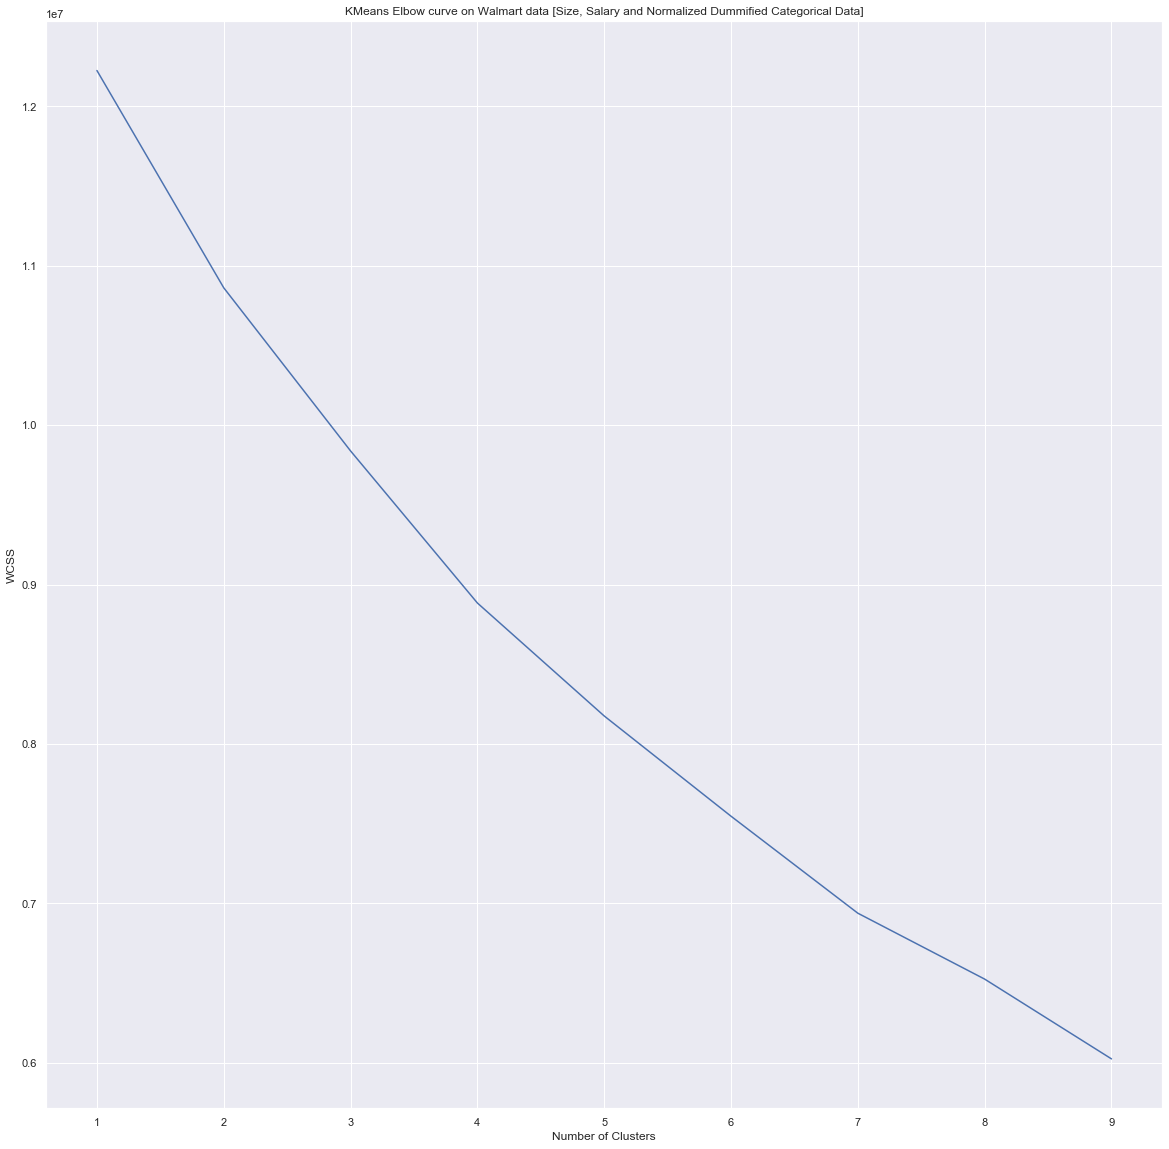

In [102]:
plt.plot(range(1,10), wcss_nd)

plt.title('KMeans Elbow curve on Walmart data [Size, Salary and Normalized Dummified Categorical Data]')
plt.ylabel('WCSS')
plt.xlabel('Number of Clusters')

plt.show()

In [103]:
#plt.plot(range(1,10), silh_score_nd)

#plt.title('Silhouette score curve on Walmart data [Size, Salary and Normalized Dummified Categorical Data]')
#plt.ylabel('Silhouette score')
#plt.xlabel('Number of Clusters')

#plt.show()

Since there is no elbow in the curve , we need to use other measure such as Silhouette Value

<a class="anchor" id ="clust_nd_kmeans_norm_3"></a>       
#### kmeans with 3 clusters



<a class="anchor" id ="clust_nd_kmeans_norm_analysis"></a>
#### Analysis of Results 




<a class="anchor" id ="clust_nd_pca"></a>
## GOAL-4: Find Principle components and then clustering on components that explain at least 70% total varaibles of data 

<a class="anchor" id ="clust_nd_pca_norm"></a>
### Normalizating whole data

In [104]:
data_pca = pd.read_pickle('dataset/walmart/dummified_data_all.pkl')
data_pca.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,day_name,isWeekend,quarter,...,March,April,May,June,July,August,September,October,November,Dec
0,1,1,2010-12-02,46039.49,True,A,151315.0,Thursday,0,4,...,0,0,0,0,0,0,0,0,0,1
1,1,1,2010-02-19,41595.55,False,A,151315.0,Friday,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2010-02-26,19403.54,False,A,151315.0,Friday,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2010-05-03,21827.90,False,A,151315.0,Monday,0,2,...,0,0,1,0,0,0,0,0,0,0
4,1,1,2010-12-03,21043.39,False,A,151315.0,Friday,0,4,...,0,0,0,0,0,0,0,0,0,1


In [105]:
data_pca.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'day_name', 'isWeekend', 'quarter', 'month', 'is_not_holiday',
       'is_holiday', 'Type_A', 'Type_B', 'Type_C', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'is_not_weekend', 'is_weekend', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4', 'Jan', 'Feb', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'Dec'],
      dtype='object')

In [106]:
pca_X= data_pca[['Weekly_Sales', 'Size', 'is_not_holiday',
       'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'is_not_weekend', 'is_weekend', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4', 'Jan', 'Feb', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'Dec']]
pca_X.head(2)

,Weekly_Sales,Size,is_not_holiday,is_holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,...,March,April,May,June,July,August,September,October,November,Dec
0,46039.49,151315.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,41595.55,151315.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
from sklearn.preprocessing import StandardScaler

In [108]:
sc = StandardScaler()
pca_X = sc.fit_transform(pca_X)
pca_X[0,:]

array([ 1.32349911,  0.23920828, -3.63495146,  3.63495146, -1.42896654,
       -0.28970908, -0.20900734, -0.25887766,  3.64434392, -0.25853844,
       -0.11900547,  0.34190518, -0.34190518, -0.54807781, -0.61191073,
       -0.60061598,  1.82216186, -0.27381262, -0.28936743, -0.3028078 ,
       -0.32940629, -0.31572211, -0.30262104, -0.31531309, -0.30201354,
       -0.31656637, -0.31626696, -0.25943534,  3.45070745])

<a class="anchor" id ="clust_nd_pca_pca"></a>
### Dimentionality Reduction / PCA

In [109]:
from sklearn.decomposition import PCA

In [110]:
pca = PCA()
new_X = pca.fit_transform(pca_X)

In [111]:
pca.explained_variance_ratio_

array([1.14350494e-01, 1.09927098e-01, 8.56830859e-02, 8.46431597e-02,
       5.30153745e-02, 5.11372200e-02, 4.44712671e-02, 4.33514797e-02,
       4.27086684e-02, 4.09112137e-02, 3.98025509e-02, 3.78661400e-02,
       3.76139601e-02, 3.72394524e-02, 3.64598685e-02, 3.18810558e-02,
       3.00290623e-02, 2.86576534e-02, 2.60313026e-02, 2.42198930e-02,
       5.97099630e-32, 4.49922916e-32, 3.72246705e-32, 2.41832973e-32,
       1.64363366e-32, 1.32838455e-32, 9.60907918e-33, 6.44408167e-34,
       9.58144474e-35])

- 1.14350494e-01 --> means 11.4% variance of data is explained by the first component,  
- 1.09927098e-01 --> 10.99% by the second component
- 8.56830859e-02 --> 8.5% by third component 
- 8.46431597e-02 --> 8.4% by fourth component 
- 5.30153745e-02 --> 5.3% by fifth component and so on 

Not much varaiance is explained by the components. For the sake of plotting we'll take the first **two** components  that explain ~ 21% variance of our data




In [112]:
pca_ = PCA(n_components=2)
reduced_X  = pca_.fit_transform(pca_X)

reduced_X.shape

(421568, 2)

<a class="anchor" id ="clust_nd_pca_kmeans"></a>
### Kmeans on Reduced X 

In [113]:
from sklearn.cluster import KMeans

In [114]:
wcss_pca = []

for i in range(1,10):    
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans_pca.fit(reduced_X)
    wcss_pca.append(kmeans_pca.inertia_)
    

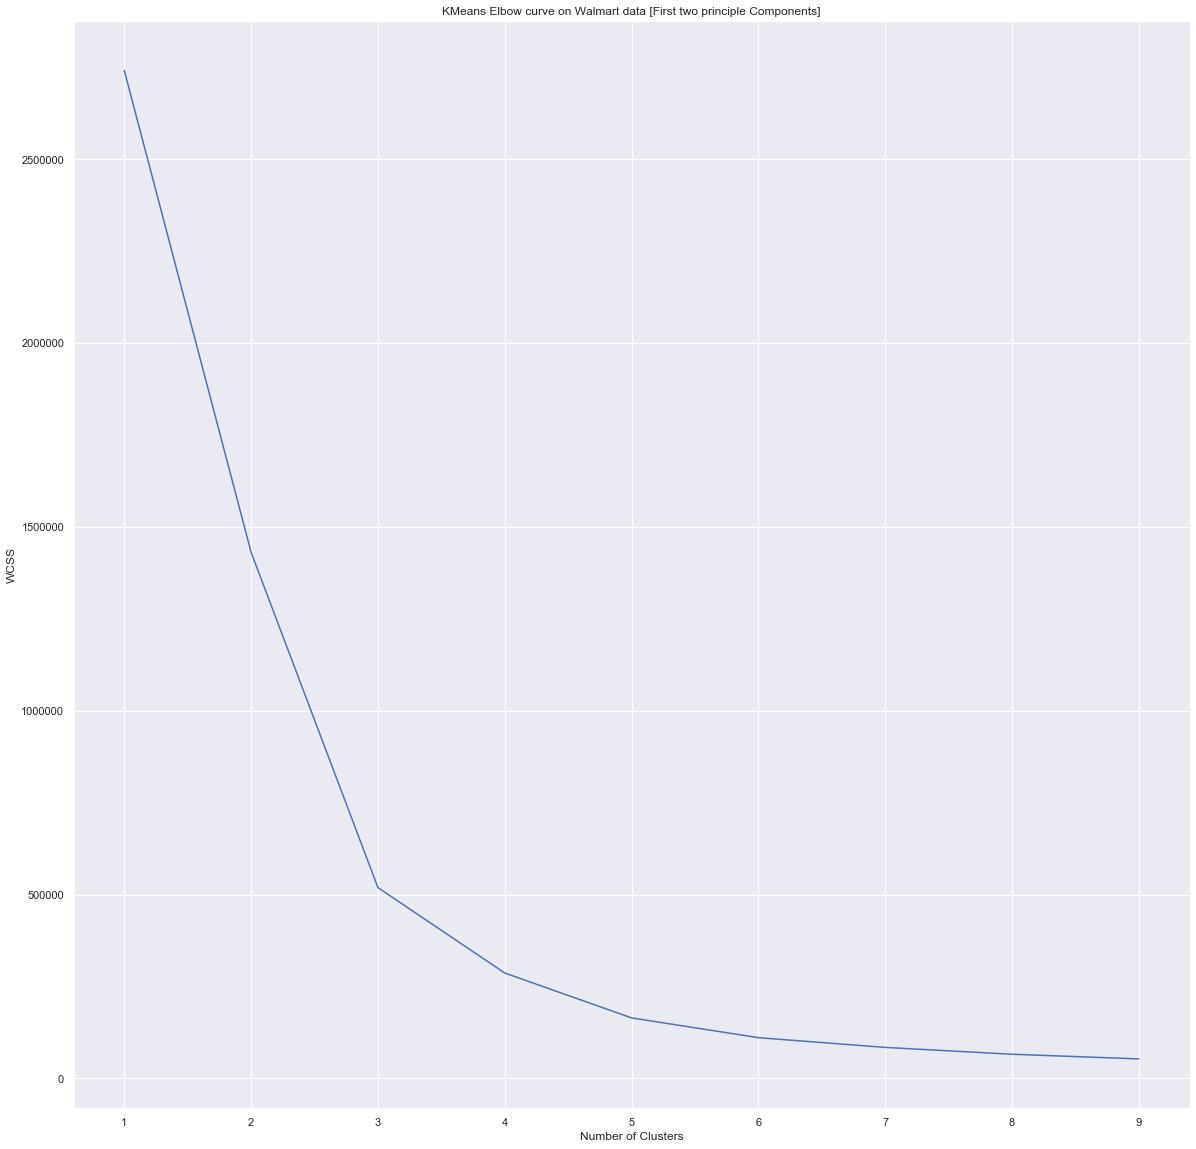

In [115]:
plt.plot(range(1,10), wcss_pca)

plt.title('KMeans Elbow curve on Walmart data [First two principle Components]')
plt.ylabel('WCSS')
plt.xlabel('Number of Clusters')

plt.show()

In [116]:
#Now Lets find 4 clusters 
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state = 0)
y_kmeans_pca = kmeans_pca.fit_predict(reduced_X)

np.unique(y_kmeans_pca)

array([0, 1, 2, 3], dtype=int32)

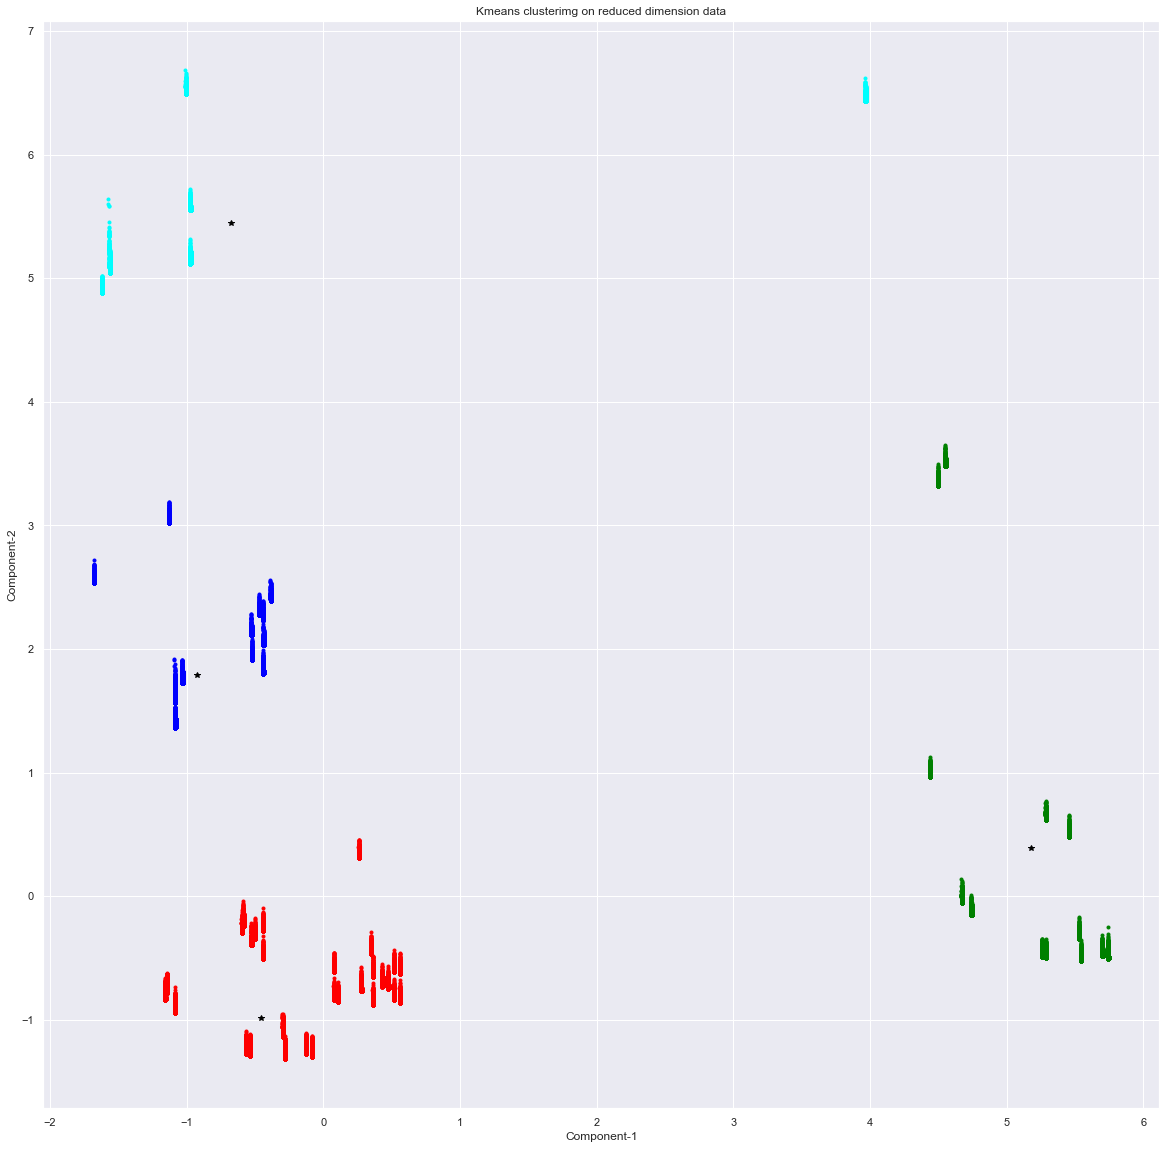

In [117]:
plt.plot(reduced_X[y_kmeans_pca == 0][:, 0], reduced_X[y_kmeans_pca == 0][:, 1], '.', color ='red', label ='Cluster-0')
plt.plot(reduced_X[y_kmeans_pca == 1][:, 0], reduced_X[y_kmeans_pca == 1][:, 1], '.', color ='green', label ='Cluster-1')
plt.plot(reduced_X[y_kmeans_pca == 2][:, 0], reduced_X[y_kmeans_pca == 2][:, 1], '.', color ='blue', label ='Cluster-2')
plt.plot(reduced_X[y_kmeans_pca == 3][:, 0], reduced_X[y_kmeans_pca == 3][:, 1], '.', color ='cyan', label ='Cluster-3')

plt.plot(kmeans_pca.cluster_centers_[:,0], kmeans_pca.cluster_centers_[:,1], '*', color='black', label='Centroid')


plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('Kmeans clusterimg on reduced dimension data')


plt.show()

In [118]:
#Now Lets find 4 clusters 
kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state = 0)
y_kmeans_pca = kmeans_pca.fit_predict(reduced_X)

np.unique(y_kmeans_pca)

array([0, 1, 2], dtype=int32)

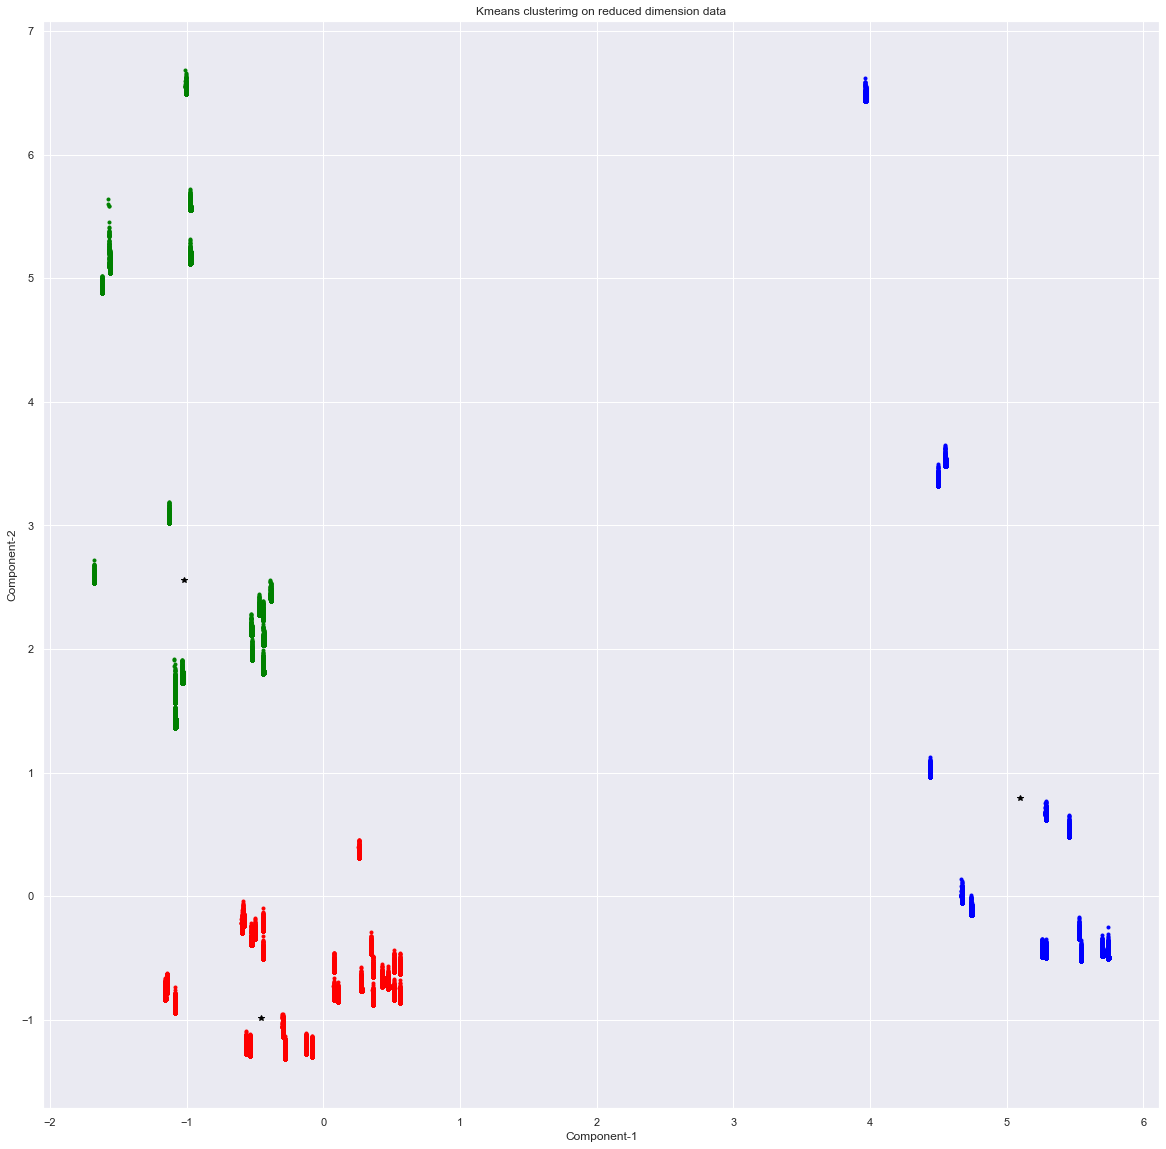

In [119]:
plt.plot(reduced_X[y_kmeans_pca == 0][:, 0], reduced_X[y_kmeans_pca == 0][:, 1], '.', color ='red', label ='Cluster-0')
plt.plot(reduced_X[y_kmeans_pca == 1][:, 0], reduced_X[y_kmeans_pca == 1][:, 1], '.', color ='green', label ='Cluster-1')
plt.plot(reduced_X[y_kmeans_pca == 2][:, 0], reduced_X[y_kmeans_pca == 2][:, 1], '.', color ='blue', label ='Cluster-2')

plt.plot(kmeans_pca.cluster_centers_[:,0], kmeans_pca.cluster_centers_[:,1], '*', color='black', label='Centroid')


plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('Kmeans clusterimg on reduced dimension data')


plt.show()

<a class="anchor" id ="clust_nd_pca_aglomerative"></a>
### Hierarchical on Reduced X 

In [120]:
import scipy.cluster.hierarchy as sch

In [121]:
#kernel died while doing this step 
#sch.dendrogram(sch.linkage(reduced_X, method='ward'))

In [122]:
from sklearn.cluster import AgglomerativeClustering